# Анализ столкновений птиц с воздушными судами

**Выполнила проект:**  
Татьяна Лисина  
Telegram @bestearthman

**Цель: изучение влияния погоды на столкновения птиц с самолетами.**  
  Проанализировать данные для проведения дальнейшего исследования и выявить закономерности в данных. На основе исследования будет построена модель предсказания столкновений птиц с самолётами.

## Общая информация

Данные собраны за 5 лет - 2018-01-01 / 2022-12-31

Датасеты:
- **data_DE_strikes_and_weather** - датасет столкновений птиц с самолетами, обогащенный погодными условиями (столкновения от FAA, погода от NCEI).  
- **flights_data_DE** - ВСЕ перелёты в ТОП-22 аэропортах по столкновениям


**Описание полей данных с переводом здесь:**  
https://docs.google.com/spreadsheets/d/1QQmrfY--7DxFnLZmkueYeUAdVOw_1sGClmkgd14lK-g/edit?usp=sharing

**Итоговые датасеты для скачивания по ссылке или с описанием в конце исследования:**  
https://drive.google.com/drive/folders/1hU4i7TnTD1oROAhVQSfCkZM4rv54CM0d?usp=sharing


In [1]:
!pip install windrose

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import datetime
from datetime import datetime

import numpy as np
import math
from scipy import stats as st
import requests

from windrose import WindroseAxes
import matplotlib.cm as cm
from numpy.random import random
from numpy import arange
from google.colab import files

## Датасеты

In [3]:
# data_DE_strikes_and_weather - все столкновения по всем аэропортам с погодой
dataset = pd.read_csv('https://drive.usercontent.google.com/download?id=1cB9qEcRdSEUqnSa_vr9u07WQY4SWEXqZ&export=download&authuser=0&confirm=t&uuid=f4f916b0-407d-4b50-9647-5e49f382cba8&at=APZUnTUccLfnMDvJ0cHp_Qgc2VAT:1696415473773', delimiter=',', dtype='unicode')
dataset

,Column1,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE_x,LONGITUDE_x,RUNWAY,STATE,FAAREGION,LOCATION,OPID,OPERATOR,REG,FLT,AIRCRAFT,AMA,AMO,EMA,EMO,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,SKY,PRECIPITATION,AOS,COST_REPAIRS,COST_OTHER,COST_REPAIRS_INFL_ADJ,COST_OTHER_INFL_ADJ,INGESTED_OTHER,INDICATED_DAMAGE,DAMAGE_LEVEL,STR_RAD,DAM_RAD,STR_WINDSHLD,DAM_WINDSHLD,STR_NOSE,DAM_NOSE,STR_ENG1,DAM_ENG1,ING_ENG1,STR_ENG2,DAM_ENG2,ING_ENG2,STR_ENG3,DAM_ENG3,ING_ENG3,STR_ENG4,DAM_ENG4,ING_ENG4,STR_PROP,DAM_PROP,STR_WING_ROT,DAM_WING_ROT,STR_FUSE,DAM_FUSE,STR_LG,DAM_LG,STR_TAIL,DAM_TAIL,STR_LGHTS,DAM_LGHTS,STR_OTHER,DAM_OTHER,OTHER_SPECIFY,EFFECT,EFFECT_OTHER,BIRD_BAND_NUMBER,SPECIES_ID,SPECIES,REMARKS,REMAINS_COLLECTED,REMAINS_SENT,WARNED,NUM_SEEN,NUM_STRUCK,SIZE,ENROUTE_STATE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE_x,PERSON,LUPDATE,TRANSFER,Unnamed: 0,ID,STATION,DATE,SOURCE_y,LATITUDE_y,LONGITUDE_y,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP
0,0,802071,2018-01-06 00:00:00.000,1,2018,NaN,NaN,KDFW,DALLAS/FORT WORTH INTL ARPT,32.89595,-97.0372,17C,TX,ASW,NaN,ENY,ENVOY AIR,N234JW,3631,EMB-170,332,NaN,22.0,4.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,Approach,300.0,133.0,NaN,No Cloud,NaN,1.0,NaN,100.0,NaN,117.0,False,False,N,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,UNKBS,Unknown bird - small,Short final about 300 ft runway 17C at DFW. on...,True,False,Unknown,2-10,2-10,Small,NaN,NaN,NaN,"2018-1-6-094630,2018-1-6-091820 /Legacy Record...",REDACTED,REDACTED,FAA Form 5200-7-E,Pilot,2018-06-30 00:00:00.000,False,183.0,802071.0,72259003927,2018-01-06 12:00:00,4,32.8978,-97.0189,170.7,"DAL FTW WSCMO AIRPORT, TX US",FM-12,99999,V020,"150,1,N,0021,1","22000,1,9,N","016000,1,9,9","+0028,1","-0011,1","10253,1"
1,1,802074,2018-01-22 00:00:00.000,1,2018,NaN,NaN,KIAH,GEORGE BUSH INTERCONTINENTAL/ HOUSTON ARPT,29.98047,-95.33972,TWY EE,TX,ASW,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,N5111,Killdeer,"DAY, 1516.",True,False,Unknown,NaN,1,Small,NaN,NaN,NaN,2018-1-22-171957 /Legacy Record=401276/,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2018-06-30 00:00:00.000,False,744.0,802074.0,72243012960,2018-01-22 12:00:00,4,29.98,-95.36,29.0,"HOUSTON INTERCONTINENTAL AIRPORT, TX US",FM-12,99999,V020,"300,1,N,0026,1","22000,1,9,N","016000,1,9,9","+0161,1","+0089,1","10144,1"
2,2,802081,2018-01-09 00:00:00.000,1,2018,12:57,Day,KTEB,TETERBORO AIRPORT,40.8501,-74.06084,24,NJ,AEA,NaN,BUS,BUSINESS,N679MS,972,EMB-500 PHENOM 100,332,NaN,31.0,NaN,A,2.0,D,2.0,5.0,5.0,NaN,NaN,Approach,NaN,NaN,2.0,Some Cloud,NaN,NaN,NaN,NaN,NaN,NaN,False,False,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,PART NOT REPTD,NaN,NaN,NaN,UNKB,Unknown bird,Pilot reported to Teterboro Tower striking a b...,False,False,Yes,1,1,NaN,NaN,NaN,NaN,"2018-1-10-074748, EXEAIRE /Legacy Record=401283/",REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,2018-06-30 00:00:00.000,False,237.0,802081.0,72502594741,2018-01-09 13:51:00,7,40.85,-74.06139,2.7,"TETERBORO AIRPORT, NJ US",FM-15,KTEB,V020,"260,5,N,0046,5","22000,5,9,N","016093,5,N,5","+0011,5","-0039,5","10210,5"
3,3,802082,2018-01-10 00:00:00.000,1,2018,NaN,NaN,KPGD,PUNTA GORDA ARPT,26.92019,-81.99053,4,FL,ASO,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [4]:
# flights_data_DE - только полеты БЕЗ столкновений (ТОП-22 аэропорта по столкновениям)
dataset_top = pd.read_csv('https://drive.usercontent.google.com/download?id=1am9a-G8V86oK1-Ty5ld6NqKtKaPleKmt&export=download&authuser=0&confirm=t&uuid=b8355e55-feae-45a2-9313-9ef03d676d28&at=APZUnTWSasXIOJ0T5qAqsrZi7kG4:1696415675164',  delimiter='|')
dataset_top

,Year,Month,DOMESTIC,INTERNATIONAL,TOTAL,airport,direction
0,2002,10,18939.0,497.0,19436,DEN,Origin
1,2002,11,17683.0,469.0,18152,DEN,Origin
2,2002,12,19168.0,510.0,19678,DEN,Origin
3,2002,TOTAL,190251.0,5090.0,195341,DEN,Origin
4,2003,1,19163.0,531.0,19694,DEN,Origin
...,...,...,...,...,...,...,...
11456,2023,2,12274.0,1242.0,13516,SEA,Destination
11457,2023,3,14045.0,1419.0,15464,SEA,Destination
11458,2023,4,14098.0,1521.0,15619,SEA,Destination
11459,2023,5,15247.0,1614.0,16861,SEA,Destination


In [5]:
df = dataset.copy()

In [6]:
top = dataset_top.copy()

## Описание данных

In [7]:
print('Данные собраны по', '\033[1m{}\033[0m'.format(df['AIRPORT_ID'].nunique()),'аэропортам.')

Данные собраны по 1535 аэропортам.


# ПРЕДОБРАБОТКА ДАННЫХ

## Дубликаты, имена столбцов

Проверим на явные дубликаты и удалим их:

In [8]:
df.duplicated().sum()
#df = df.drop_duplicates()

0

In [9]:
top.duplicated().sum()


0

Явных дубликатов строк нет.

Понизим регистр всех названий столбцов и переименуем некоторые короче. Удалим пустые и лишние столбцы.

In [10]:
df = df.drop(columns=['Column1','REPORTED_NAME','REPORTED_TITLE','TRANSFER','LATITUDE_y','LONGITUDE_y','LUPDATE','Unnamed: 0'], axis=1)
df.columns = df.columns.str.lower()
df = df.rename(columns={'incident_month':'month','incident_year':'year'})

In [11]:
# для удобства поставим столбец даты со временем рядом с датой события
date_new = df['date']
df.insert(2, 'date_new', date_new)
df = df.drop(columns={'date'})
df = df.rename(columns={'date_new':'date'})

In [12]:
df['indicated_damage'] = df['indicated_damage'].str.lower()

In [13]:
top.columns = top.columns.str.lower()
top = top.rename(columns={'airport':'airport_id'})

In [14]:
#сохраним резервную копию датасета для проверки:
df_copy = df.copy()

Удалим строки TOTAL с агрегирующими данными по перелетам за год (они будут искажать сумму перелетов при дальнейшей агрегации).

In [15]:
top_by_year = top.query('month == "TOTAL"').copy()
top = top.query('month != "TOTAL"').copy()

## Даты и время

### Перевод форматов

Переведем в датасете top месяцы в формат чисел:

In [16]:
top['month'] = top['month'].astype('int')

Переведем в датасете df столбцы incident_date, date, year в соответствующий формат:

In [17]:
# set the column type as a str if it isn't already
df['incident_date'] = df['incident_date'].astype('str')

# create a date mask based on the string containing a /
date_mask = df['incident_date'].str.contains(':')

# split the dates out for excel
df_excel = df[~date_mask].copy()
# split the regular dates out
df_reg = df[date_mask].copy()

# convert reg dates to datetime
df_reg['incident_date'] = pd.to_datetime(df_reg['incident_date'], format='%Y-%m-%d')
# convert excel dates to datetime; the column needs to be cast as ints
df_excel['incident_date'] = pd.TimedeltaIndex(df_excel['incident_date'].astype(int), unit='d') + datetime(1900, 1, 1)

# combine the dataframes
df = pd.concat([df_reg, df_excel])

In [18]:
print(df['incident_date'].notnull().sum())
print(df['incident_date'].isna().sum())

86872
0


In [19]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S')

In [20]:
print(df['date'].notnull().sum())
print(df['date'].isna().sum())

74622
12250


In [21]:
df[['year','month']] = df[['year','month']].astype(int)

Переведём столбец time в формат времени:

In [22]:
# значения nan не распознаются, как пропуски, поправим это
df['time'] = df['time'].replace('nan', value=np.nan, regex=True)
print('Количество пропусков в столбце время:', df['time'].isna().sum())

Количество пропусков в столбце время: 15842


In [23]:
# переведем в формат строки и удалим некорректное время
df['time'] = df['time'].astype('str')
# Заменим некорректные строки с символом '%' на пустые:
df['time'] = df['time'].replace(to_replace='%', value=np.nan, regex=True)
# заменим некорректные ячейки на пропуски
df.loc[df['time'].str.len() == 6, 'time'] = np.NaN

In [24]:
# Переведем ячейки времени, содержащие AM и PM:
time_format = '%I:%M:%S %p'

# Преобразование строки в объект datetime и перевод в 24-часовой формат, удаление секунд
for index, value in df['time'].items():
    if pd.notna(value):
        if len(value) == 11: # строка длиной в 11 символов
            df.at[index, 'time'] = datetime.strptime(value, '%I:%M:%S %p').strftime('%H:%M')
        if len(value) == 10:  # строка длиной в 10 символов, добавление пропущенного нуля вначале
            df.at[index, 'time'] = datetime.strptime(value.zfill(8), time_format).strftime('%H:%M')

In [25]:
# переведем время из формата str в формат datetime (часы и минуты)
# прочих ошибок во времени осталось немного, заменим их на пропуски
df['time'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.time

In [26]:
# проверим форматы и количество полезных строк
df['time'].apply(type).value_counts()

<class 'datetime.time'>                          70540
<class 'pandas._libs.tslibs.nattype.NaTType'>    16332
Name: time, dtype: int64

In [27]:
# создадим на будущее столбец только с часами (округление времени в меньшую сторону)
df['hour'] = df['time'].apply(lambda x: x.replace(minute=0, second=0))
df['hour'] = df['hour'].apply(lambda x: x.strftime('%H') if pd.notna(x) else None)

### Диапазоны дат

In [28]:
print(df['incident_date'].min())
print(df['incident_date'].max())

2018-01-01 00:00:00
2023-08-30 00:00:00


In [29]:
print(df['date'].min())
print(df['date'].max())

2018-01-01 10:53:00
2023-08-30 19:52:00


In [30]:
print(df['year'].min())
print(df['year'].max())

2018
2023


In [31]:
min_time = df['time'].dropna().min()
max_time = df['time'].dropna().max()
print(min_time.strftime('%H:%M'))
print(max_time.strftime('%H:%M'))

00:00
23:59


Данные собраны за больший период, чем заявлено в ТЗ - за 5 лет и 8 месяцев (вместо 5 лет). Оставим эти данные, они не ошибочны, в нашем случае, чем больше данных, тем лучше.

Проверим диапазон данных датасета top:

In [32]:
print(top['year'].min())
print(top['year'].max())

2002
2023


Оставим в данных события только за нужный промежуток времени с 2018 по 2023 года.

<Axes: >

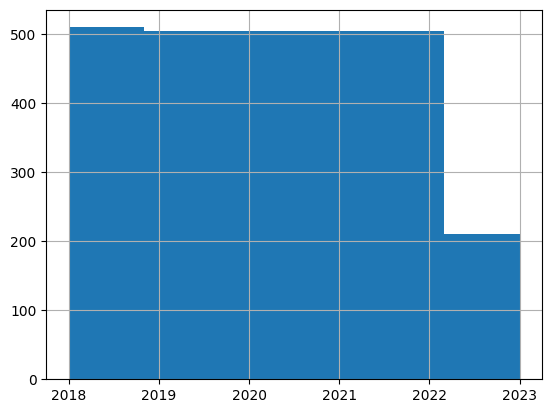

In [33]:
top = top.query('year > 2017')
top['year'].hist(bins=6)

### Равномерность данных по годам

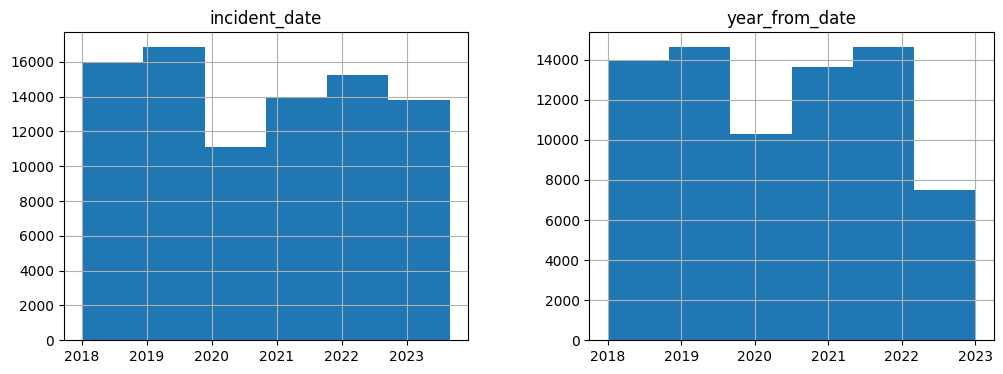

In [34]:
# создадим а затем удалим добавочный столбец для гистограммы
df['year_from_date'] = df.date.dt.year
df[['incident_date','year_from_date']].hist(bins=6, figsize=(12,4));

In [35]:
df = df.drop(columns=['year_from_date'], axis=1)

Данные по годам представлены равномерно (спад в 2020 объясняется ограничением на полёты из-за коронавируса, спад в 2023 тем, что данные собраны только за 8 месяцев). В date есть пропуски, в этих строках будем ориентироваться на incident_date.  

In [36]:
# проверим совпадают ли годы инцидента и отчета
df.query('year != date.dt.year & date.dt.year.notnull()').shape

(13, 112)

In [37]:
# удалим 13 строк, в которых указаны сразу два года
bad_date = df.query('year != date.dt.year & date.dt.year.notnull()')
df = df[~df['index_nr'].isin(bad_date['index_nr'])]

## Очистка от НЕ птиц

Проверим вид животного в столбцах species_id и species на соответствие птице.  
До очистки данных создадим копию датасета - df_full, по ней проверим процент удаленных строк.

In [38]:
print('Всего в датасете', df['species_id'].nunique(), 'видов животных.')

Всего в датасете 758 видов животных.


In [39]:
df_full = df.copy()

Из данных ICAO мы знаем, что маркировка птиц начинается с буквы "C", и не может начинаться с цифры 1 или 2. Очистим датасет от лишних строк по ID. А заодно выведем оставшиеся ID и проверим визуально на аномалии.

In [40]:
df = df[~df['species_id'].fillna('unknown').str.startswith(('1','2'))]
df['species_id'].unique()

array(['UNKBS', 'N5111', 'UNKB', 'ZT301', 'N6011', 'NE121', 'UNKBL',
       'N5122', 'ZT002', 'UNKBM', 'NE108', 'N6019', 'R1101', 'YH004',
       'O2205', 'ZT001', 'R2004', 'YI010', 'O2111', 'ZS009', 'N5105',
       'J2106', 'M7005', 'R2001', 'ZX303', 'YL001', 'K3302', 'NE115',
       'I1203', 'O2211', 'Y', 'K1', 'N6016', 'Z6007', 'ZX3', 'NE101',
       'K3502', 'N5123', 'N6039', 'K2001', 'I1105', 'O2203', 'K33',
       'K5114', 'J22', 'L4302', 'K1002', 'K3304', 'J2109', 'J2104', 'R',
       'N6009', 'R2009', 'NE104', 'ZX505', 'ZT000', 'I1301', 'O22',
       'K3101', 'NE120', 'ZX313', 'YM201', 'K3311', 'ZX018', 'J2202',
       'NG201', 'E1001', 'ZD102', 'NE1', 'NE139', 'UNKBB', 'K1001',
       'YM11', 'K3303', 'N5125', 'N6', 'H1', 'ZZ201', 'ZH002', 'ZC204',
       'ZX315', 'J2130', 'J2113', 'I1102', 'ZS028', 'N5205', 'ZX305',
       'I1111', 'J2204', 'ZX302', 'ZC205', 'ZH001', 'J2131', 'N6034',
       'F1004', 'YI005', 'ZX328', 'X6101', 'ZT101', 'ZX312', 'T1007',
       'ZS013', 'H1001

Видим подозрительное значение "30" и пустую ячейку nan. Проверим их.  
Короткие ID всего из одной или двух букв - корректны, так обозначают семейство птиц без указания породы.

In [41]:
# проверим подозрительный id - 30, если это не птица - удалим
df[['species_id','species']].query('species_id == "30"')

,species_id,species
61258,30,Insect
61540,30,Insect


In [42]:
# удалим случаи с насекомыми
df = df.query('species_id != "30"')

Найдем пустую строку и проверим что это птица.

In [43]:

df[['species_id','species']].query('species_id.isna()')

,species_id,species
62660,NaN,Killdeer (Charadrius vociferus)


In [44]:
# в пустой строке птица - добавим ее id
df.loc[df['species_id'].isna(), 'species_id'] = 'N5111'

In [45]:
df['species_id'].nunique()

632

In [46]:
df.shape

(82206, 112)

In [47]:
df['species'].value_counts().head(10)

Unknown bird             13690
Unknown bird - small     11100
Mourning dove             5066
Barn swallow              4074
Killdeer                  3688
Horned lark               3352
American kestrel          3076
Unknown bird - medium     2500
Eastern meadowlark        1919
European starling         1547
Name: species, dtype: int64

In [48]:
print('_' * 130)
print()
print('\033[1mИТОГО\033[0m')
print()
print('Мы удалили', '\033[1m{}\033[0m'.format(df_full['species_id'].nunique() - df['species_id'].nunique()),
      'вида животных, не являющихся птицами - осталось', '\033[1m{}\033[0m'.format(df['species_id'].nunique()),
      'вида птиц (в том числе неопознанных).')
print('Также избавились от','\033[1m{}\033[0m'.format((len(df_full) - len(df))),
      'несоответствующих строк, что является не более',
      '\033[1m{}\033[0m'.format(round((len(df_full) - len(df)) / len(df_full) * 100)),'% от датасета.') #жирный шрифт
print()
print('Интересное наблюдение: более чем в 30% случаев птица была неопознана.')
print('В топ-5 по столкновениям птиц входят мелкие птицы -','\033[1m{}\033[0m'.format('траурный голубь, сарайная ласточка и крикливый зуёк.'))

__________________________________________________________________________________________________________________________________

ИТОГО

Мы удалили 126 вида животных, не являющихся птицами - осталось 632 вида птиц (в том числе неопознанных).
Также избавились от 4653 несоответствующих строк, что является не более 5 % от датасета.

Интересное наблюдение: более чем в 30% случаев птица была неопознана.
В топ-5 по столкновениям птиц входят мелкие птицы - траурный голубь, сарайная ласточка и крикливый зуёк.


## Данные о погоде

Разделим данные о погоде на несколько столбцов, чтобы мы могли к ним обращаться отдельно:

In [49]:
df[['wind_direct','w_qc_direct','w_type','w_speed_gor','w_qc_speed']] = df['wnd'].str.split(',', expand=True)
df[['cig_dist_sky','cig_qc','method','cavok']] = df['cig'].str.split(',', expand=True)
df[['vis_gor','vis_qc','volatile','vol_qc']] = df['vis'].str.split(',', expand=True)
df[['temp','t_qc']] = df['tmp'].str.split(',', expand=True)
df[['dew_point','dew_qc']] = df['dew'].str.split(',', expand=True)
df[['slp_pressure','slp_qc']] = df['slp'].str.split(',', expand=True)
df = df.drop(columns=['wnd','cig','vis','tmp','dew','slp'], axis=1)

**Примечание:** из документа "FEDERAL CLIMATE COMPLEX, DATA DOCUMENTATION FOR INTEGRATED SURFACE DATA (ISD)" мы знаем, что значения в погодных столбцах 999 и 9999 - означают некорректные данные. Оставим их как есть, но не будем использовать для анализа.


## Формат данных

In [50]:
df['index_nr'] = df['index_nr'].astype(int)

In [51]:
#print(list(df.columns))

In [52]:
columns_to_convert = ['latitude_x','longitude_x','num_engs','height','speed','distance','bird_band_number','num_seen',
                      'num_struck','elevation','wind_direct','w_qc_direct','w_type','w_speed_gor','w_qc_speed','cig_dist_sky',
                      'cig_qc','method','cavok','vis_gor','vis_qc','volatile','vol_qc','temp','t_qc','dew_point','dew_qc',
                      'slp_pressure','slp_qc']
# Заменим ячейки с буквами на пропуски NaN
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Теперь преобразуем все столбцы к типу данных float
df[columns_to_convert] = df[columns_to_convert].astype(float)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82206 entries, 0 to 86871
Columns: 125 entries, index_nr to slp_qc
dtypes: datetime64[ns](2), float64(29), int64(3), object(91)
memory usage: 79.0+ MB


## Перевод единиц измерения

Переведём температуру и точку росы в привычный формат градусов:

In [54]:
df['temp'] = df['temp'] / 10

In [55]:
df['dew_point'] = df['dew_point'] / 10

Переведём скорость ветра в стандартные единицы - м/с:

In [56]:
df['w_speed_gor'] = (df['w_speed_gor'] / 10)

## Создание профильных датасетов

Создадим сокращенный датасет **df**, оставив только необходимые столбцы. Сохраним его полную копию в **df_full**.


In [57]:
df_full = df.copy()

In [58]:
# сгенерируем список столбцов и оставим только нужные
#columns = list(df.columns)
#columns

In [59]:
useful_columns = ['index_nr','incident_date','date','month','year','time','hour','time_of_day',
 'airport_id','airport','latitude_x','longitude_x','runway','state','location',
 'type_eng','num_engs','phase_of_flight','height','speed','distance','sky','precipitation',
 'indicated_damage','damage_level','effect','effect_other','bird_band_number','species',
 'remains_collected','num_seen','num_struck','size','elevation','wind_direct','w_qc_direct',
 'w_type','w_speed_gor','w_qc_speed','cig_dist_sky','cig_qc','method','cavok','vis_gor',
 'vis_qc','volatile','vol_qc','temp','t_qc','dew_point','dew_qc','slp_pressure','slp_qc']

In [60]:
# создаем сокращенный датафрейм на основе копии главного
# *** удалить позже еще ненужные столбцы
df = df[useful_columns].copy()

## Аномалии

In [61]:
top['airport_id'].value_counts()

DEN    130
DFW    130
DAL    130
IAH    130
RSW    130
FLL    130
MCI    130
AUS    130
TPA    130
LAX    130
CLT    130
SLC    130
SDF    130
CVG    130
MCO    130
JFK    130
DTW    130
MEM    130
ATL    130
ORD    130
SEA    130
TEB      8
Name: airport_id, dtype: int64

In [62]:
top.query('airport_id == "TEB"')

,year,month,domestic,international,total,airport_id,direction
10853,2018,6,1.0,NaN,1,TEB,Origin
10854,2018,7,1.0,NaN,1,TEB,Origin
10856,2022,11,1.0,NaN,1,TEB,Origin
10914,2018,6,1.0,NaN,1,TEB,Destination
10915,2018,9,75.0,NaN,75,TEB,Destination
10916,2018,10,23.0,NaN,23,TEB,Destination
10917,2018,11,16.0,NaN,16,TEB,Destination
10919,2019,4,7.0,NaN,7,TEB,Destination


По аэропорту TEB (Тетерборо, штат Нью-Джерси) данных очень мало и они заполнены некорректно, удалим его из ТОП.

In [63]:
top = top.query('airport_id != "TEB"').copy()

# ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

## ТОП-10 АЭРОПОРТОВ

Построим тепловую карту полётов по месяцам для ТОП-10 аэропортов, самых популярных по столкновению с птицами.

Обозначения IKAO и IATA отличаются на первую букву "K" - добавим её  к ID аэропортам в датасет **top**:

In [64]:
# добавим символа к ID аэропорта
top['airport_id'] = 'K' + top['airport_id']

In [65]:
top_10_heatmap = top.pivot_table(index=['year','month'], columns='airport_id', values='total')
top_10_heatmap = top_10_heatmap[['KORD','KATL','KDFW','KDEN','KCLT','KJFK','KDTW','KMCO','KSLC','KMEM']]

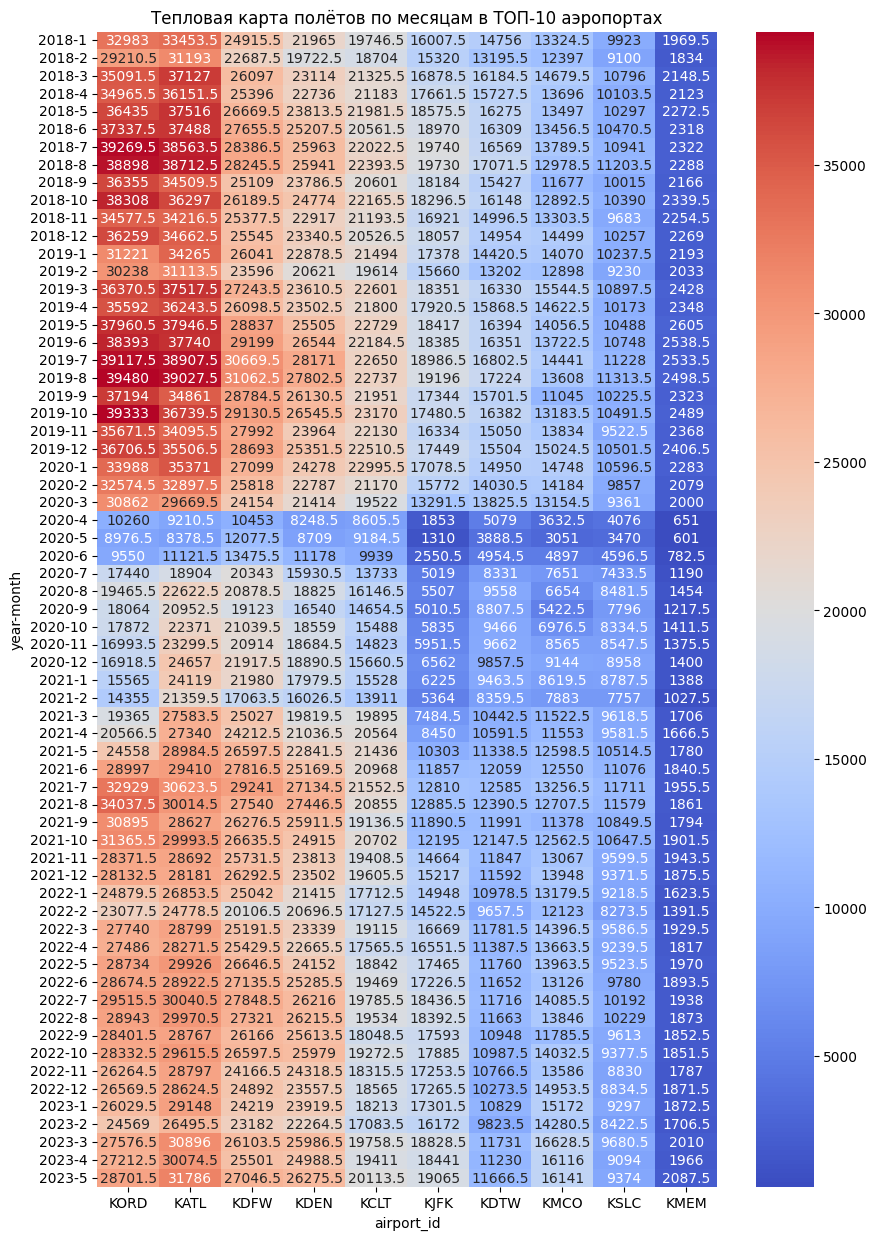

In [66]:
plt.figure(figsize=(10,15))
sns.heatmap(top_10_heatmap, annot=True, cmap='coolwarm', fmt='g')
plt.title('Тепловая карта полётов по месяцам в ТОП-10 аэропортах')
plt.show()

Явно видим зависимость количества полётов от сезона года:
*   летом (июль, август) полетов больше
*   зимой (январь, февраль) - меньше

Также в 2020 году (апрель, май, июнь) - видим существенный спад перелетов во всех аэропортах, причиной этого может быть локдаун из-за Коронавируса.



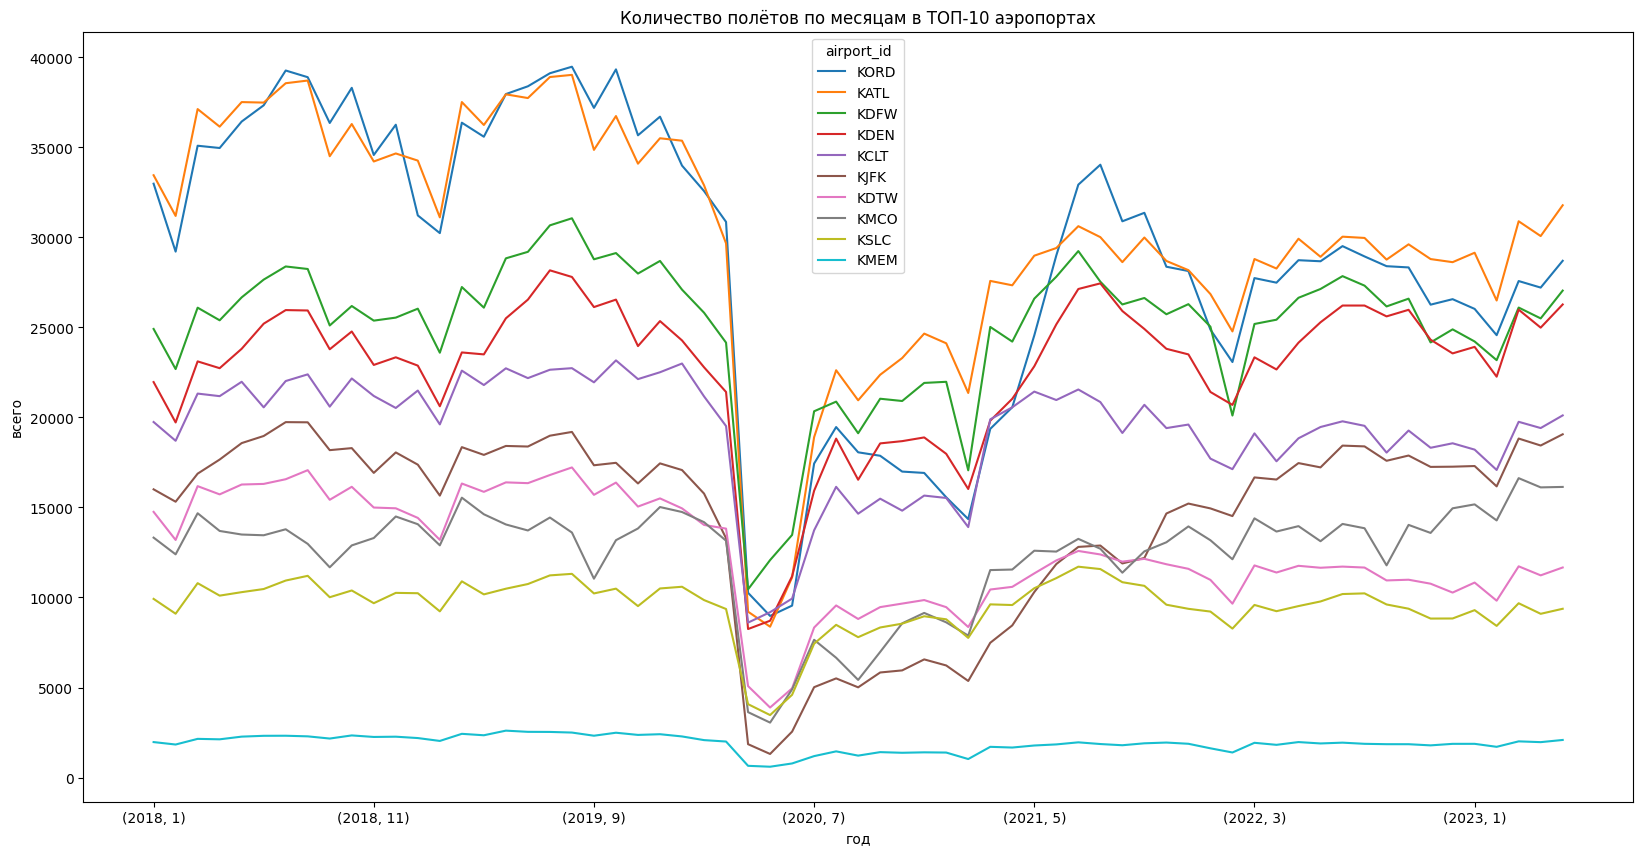

In [67]:
top_10_heatmap.plot(figsize=(20, 10))
plt.title('Количество полётов по месяцам в ТОП-10 аэропортах')
plt.xlabel('год')
plt.ylabel('всего')
plt.show()

Взлеты и спады линий по месяцам повторяют друг друга в разных аэропортах. Только линия аэропорта KMEM (Мемфис) практически не зависит от сезонности и сильно отличается от остальных (крупнейший по грузовым перевозкам).



## Сумма полётов со столкновениями по аэропортам

In [68]:
print('Данные собраны по', '\033[1m{}\033[0m'.format(df['airport_id'].nunique()),'аэропортам.')

Данные собраны по 1442 аэропортам.


Посчитаем количество столкновений в ТОП-22 аэропортах за 5 лет и 8 месяцев:

In [69]:
strikes_by_airport = (df.pivot_table(index='airport_id', values='index_nr', aggfunc='count')
                        .sort_values(by='index_nr', ascending=False).head(22).reset_index())
strikes_by_airport = strikes_by_airport.rename(columns={'index_nr':'strikes'})

fig = px.bar(strikes_by_airport, x='airport_id', y='strikes', title='Количество столкновений с птицами по аэропортам')
fig.update_xaxes(tickangle=45)
fig.show()

**Примечание:**    
Специальный указатель ZZZZ зарезервирован для случаев, когда составляется план полёта в аэропорт, не имеющий кода ИКАО.  
(во всех строках airport_id со значением ZZZZ аэропорт также не определён)

In [70]:
unknown_strikes = round((len(df.query('airport_id == "ZZZZ"')) / len(df))*100)
print()
print('\033[1m{}\033[0m'.format(unknown_strikes),
      '\033[1m{}\033[0m'.format('% столкновений произошли в небольших аэропортах, которые не зарегистрированы в ИКАО.'))


14 % столкновений произошли в небольших аэропортах, которые не зарегистрированы в ИКАО.


ТОП-5 аэропортов по количеству столкновений - **KATL** (Атланта, штат Джорждия), **KDFW** (Даллас), **KDEN** (Денвер), **KORD** (О'Хара в Чикаго, штат Иллинойс), **KMEM** (Мемфис). Это не удивительно, ведь все из них, кроме KMEM, входят в ТОП-20 самых загруженных аэропортов мира и в них в принципе гораздо больше перелетов. Аэропорт KMEM рассмотрим далее отдельно, как исключение.

Большое количество столкновений в аэропорту может быть критерием для принятия дополнительных мер безопасности.  
Но нужно также проверить отношение столкновений к количеству всех перелётов.

## Процент столкновений к успешным перелетам в ТОП-22 аэропортах

Совместим данные со всеми перелетами в **top** с данными о столкновениях в **df** по уникальному ID аэропорта. Найдём процент столкновений в перелётах.

Сагрегируем события в главном датафрейме только по интересующим нас аэропортам:

In [71]:
# лист топовых аэропортов
top_22 = list(top['airport_id'].unique())

In [72]:
# датасет со столкновениями с птицами по топовым 22 аэропортам
df_by_month = (df.query('airport_id == @top_22')
 .pivot_table(index=['year','month','airport_id'], values='airport', aggfunc='count').reset_index())
df_by_month = df_by_month.rename(columns={'airport':'total_birds'})
df_by_month.head(3)

,year,month,airport_id,total_birds
0,2018,1,KATL,7
1,2018,1,KAUS,4
2,2018,1,KCLT,4


In [73]:
# суммируем все вылеты и прилеты в столбце total (нас интересует общее число перелетов в аэропорте)
top_total = (top
           .pivot_table(index=['year','airport_id','month'], values = 'total', aggfunc='sum')
           .reset_index())
top_total

,year,airport_id,month,total
0,2018,KATL,1,66907
1,2018,KATL,2,62386
2,2018,KATL,3,74254
3,2018,KATL,4,72303
4,2018,KATL,5,75032
...,...,...,...,...
1360,2023,KTPA,1,14162
1361,2023,KTPA,2,13362
1362,2023,KTPA,3,16195
1363,2023,KTPA,4,15766


In [74]:
# соединим данные по всем перелетам и перелетам со столкновениями для топ-21 аэропортов
flight_ratio = top_total.merge(df_by_month, on=['year','airport_id','month'], how='left')
# пропуски в данных
flight_ratio[flight_ratio['total_birds'].isna()].sort_values(by='year').value_counts('airport_id')

airport_id
KMCI    4
KDAL    2
KDTW    2
KIAH    2
KCLT    1
KMCO    1
KMEM    1
KSEA    1
KSLC    1
KTPA    1
dtype: int64

Пропущенных данных не много, оставим как есть.

In [75]:
flight_ratio['ratio_%'] = (flight_ratio['total_birds']/flight_ratio['total']*100).round(2)

In [76]:
flight_ratio

,year,airport_id,month,total,total_birds,ratio_%
0,2018,KATL,1,66907,7.0,0.01
1,2018,KATL,2,62386,12.0,0.02
2,2018,KATL,3,74254,11.0,0.01
3,2018,KATL,4,72303,23.0,0.03
4,2018,KATL,5,75032,15.0,0.02
...,...,...,...,...,...,...
1360,2023,KTPA,1,14162,13.0,0.09
1361,2023,KTPA,2,13362,5.0,0.04
1362,2023,KTPA,3,16195,9.0,0.06
1363,2023,KTPA,4,15766,8.0,0.05


In [77]:
# средний процент столкновений по годам
ratio_year = flight_ratio.pivot_table(index=['year'], columns='airport_id', values='ratio_%').round(2)
ratio_year

airport_id,KATL,KAUS,KCLT,KCVG,KDAL,KDEN,KDFW,KDTW,KFLL,KIAH,KJFK,KLAX,KMCI,KMCO,KMEM,KORD,KRSW,KSDF,KSEA,KSLC,KTPA
year,,,,,,,,,,,,,,,,,,,,,
2018,0.03,0.11,0.04,0.13,0.12,0.07,0.05,0.08,0.04,0.03,0.05,0.02,0.19,0.04,0.48,0.03,0.16,0.29,0.03,0.09,0.09
2019,0.03,0.12,0.04,0.17,0.09,0.07,0.06,0.06,0.04,0.03,0.06,0.03,0.14,0.08,0.38,0.04,0.26,0.33,0.03,0.08,0.08
2020,0.03,0.14,0.03,0.40,0.13,0.12,0.07,0.08,0.06,0.04,0.11,0.05,0.21,0.06,1.03,0.05,0.17,0.54,0.04,0.09,0.08
2021,0.03,0.09,0.04,0.19,0.10,0.10,0.07,0.08,0.06,0.04,0.08,0.03,0.14,0.07,0.47,0.05,0.16,0.38,0.03,0.06,0.09
2022,0.04,0.08,0.04,0.21,0.11,0.12,0.05,0.09,0.07,0.05,0.06,0.02,0.13,0.07,0.65,0.05,0.20,0.36,0.04,0.09,0.08
2023,0.03,0.09,0.02,0.11,0.11,0.07,0.04,0.03,0.04,0.06,0.04,0.03,0.12,0.05,0.56,0.03,0.07,0.24,0.03,0.06,0.08


In [78]:
ratio_month = flight_ratio.pivot_table(index=['year','month'], columns='airport_id', values='ratio_%').round(2)

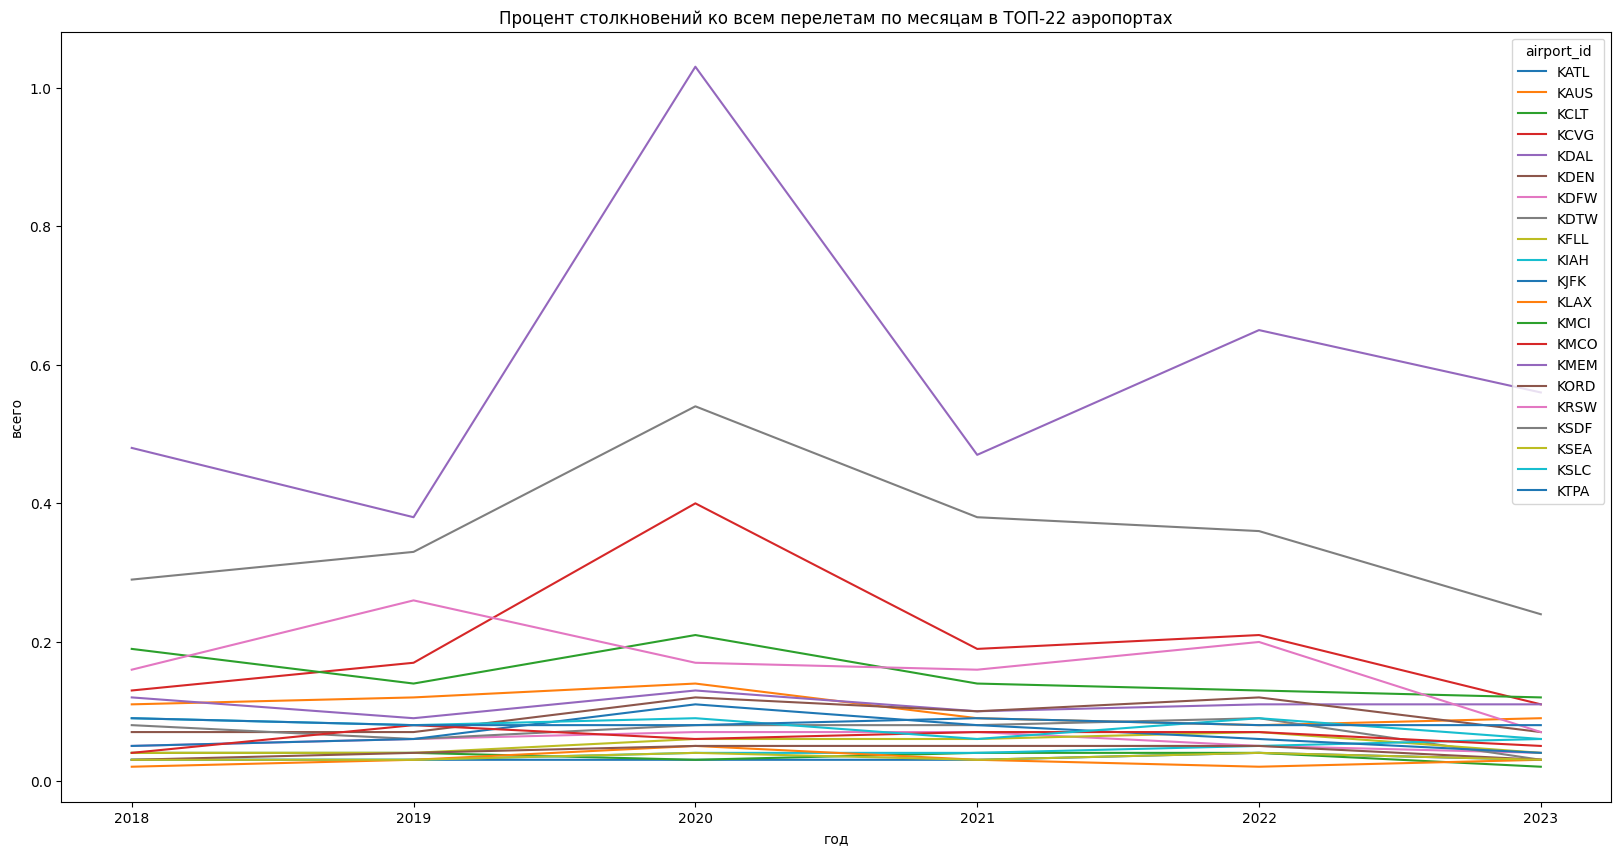

In [79]:
ratio_year.plot(figsize=(20, 10))
plt.title('Процент столкновений ко всем перелетам по месяцам в ТОП-22 аэропортах')
plt.xlabel('год')
plt.ylabel('всего')
plt.show()

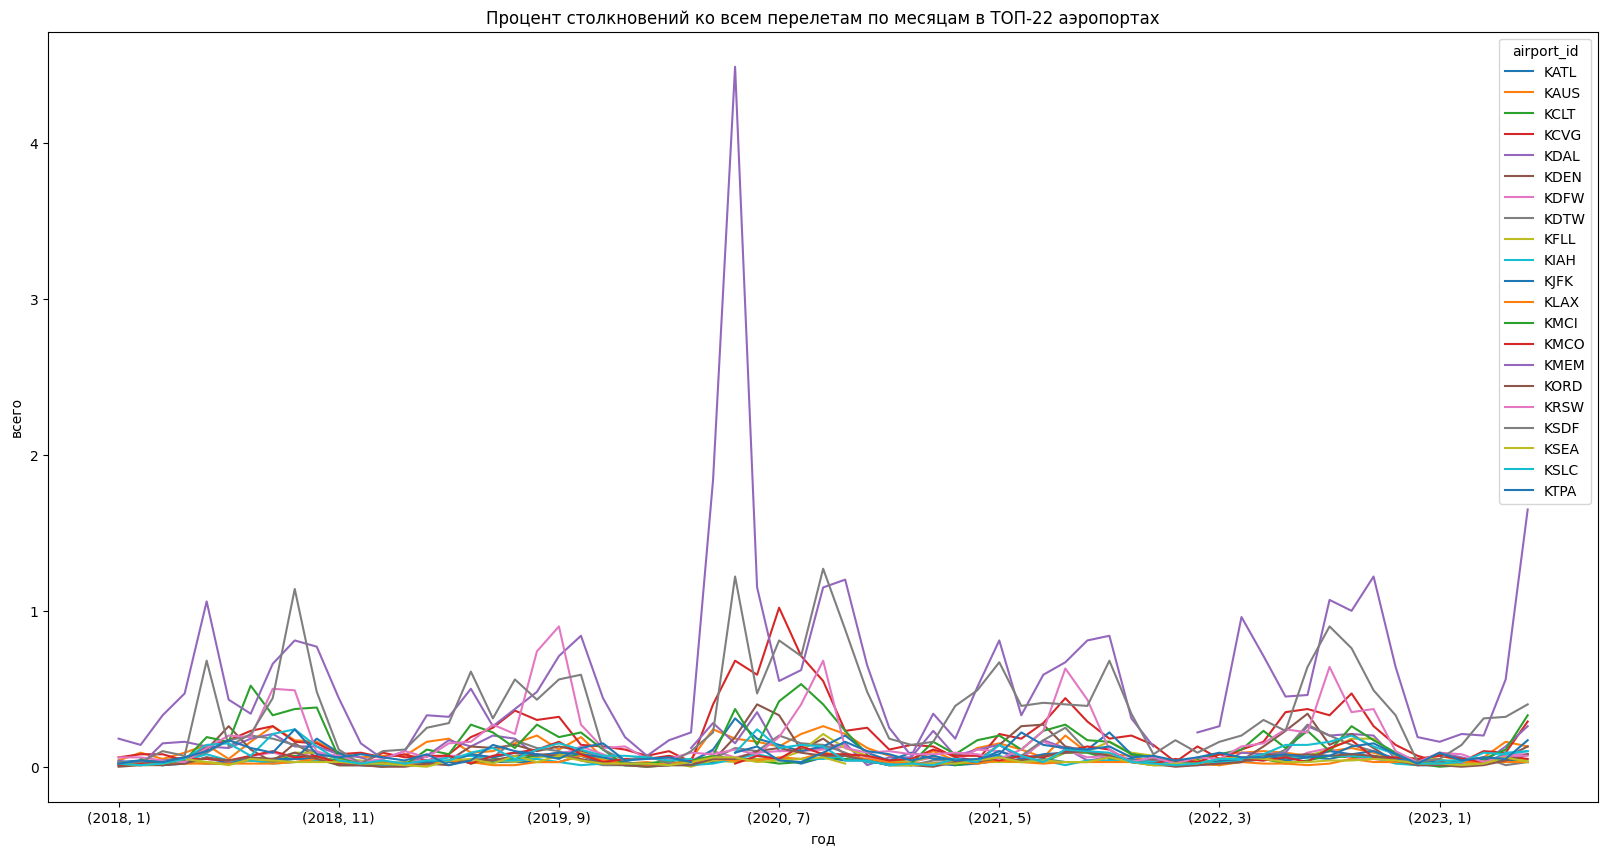

In [80]:
ratio_month.plot(figsize=(20, 10))
plt.title('Процент столкновений ко всем перелетам по месяцам в ТОП-22 аэропортах')
plt.xlabel('год')
plt.ylabel('всего')
plt.show()

In [81]:
top_5 = (flight_ratio.pivot_table(index='airport_id', values='ratio_%', aggfunc='mean')
                     .round(2).reset_index().sort_values(by='ratio_%', ascending=False).head(5))
top_5

,airport_id,ratio_%
14,KMEM,0.60
17,KSDF,0.37
3,KCVG,0.21
16,KRSW,0.18
12,KMCI,0.16


Топовые аэропорты по проценту столкновений с птицами - это **KMEM** (Мемфис, штат Теннесси) и **KSDF** (Луисвилль, штат Кентуки).

Видим, аномальный пик у аэропорта KMEM в мае 2020 года, проверим его:

In [82]:
flight_ratio.query('airport_id == "KMEM" & year==2020')

,year,airport_id,month,total,total_birds,ratio_%
672,2020,KMEM,1,4566,3.0,0.07
673,2020,KMEM,2,4158,7.0,0.17
674,2020,KMEM,3,4000,9.0,0.22
675,2020,KMEM,4,1302,24.0,1.84
676,2020,KMEM,5,1202,54.0,4.49
677,2020,KMEM,6,1565,18.0,1.15
678,2020,KMEM,7,2380,13.0,0.55
679,2020,KMEM,8,2908,18.0,0.62
680,2020,KMEM,9,2435,28.0,1.15
681,2020,KMEM,10,2823,34.0,1.20


Количество полётов в мае меньше обычного (предположительно из-за ограничений ковида), при этом столкновений с птицами больше. Есть равномерное увеличение и уменьшение столкновений по месяцам, на ошибку в данных не похоже.

## Функции

In [83]:
# функция сводной таблицы и гистограммы по ней
def px_bar (df, index_1, values_1, title_1):
  table = df.pivot_table(index=index_1, values=values_1, aggfunc='count').reset_index()
  table = table.rename(columns={values_1:'amount'})

  fig = px.bar(table, x=index_1, y='amount', title=title_1)
  #fig.update_xaxes(tickangle=45)
  return fig.show()

In [84]:
# функция сводной таблицы и гистограммы по ней + сортировка объёма
def px_sort (df, index_1, values_1, title_1, h, w):
  table = df.pivot_table(index=index_1, values=values_1, aggfunc='count').reset_index()
  table = table.rename(columns={values_1:'amount'})
  table = table.sort_values(by='amount',ascending=False)

  fig = px.bar(table, x=index_1, y='amount', title=title_1)
  fig.update_layout(height=h, width=w)
  #fig.update_xaxes(tickangle=45)
  return fig.show()

In [85]:
# функция сводной таблицы и гистограммы по ней + сортировка объёма
def px_sort_size (df, index_1, values_1, title_1, h, w, min_value, max_value):
  table = df.pivot_table(index=index_1, values=values_1, aggfunc='count').reset_index()
  table = table.rename(columns={values_1:'amount'})
  table = table.sort_values(by='amount',ascending=False)

  fig = px.bar(table, x=index_1, y='amount', range_x=[min_value, max_value], title=title_1)
  fig.update_layout(height=h, width=w)
  #fig.update_layout(height=h, width=w, title=title_1, xaxis=dict(range=[min_value, max_value]))
  #fig.update_xaxes(tickangle=45)
  return fig.show()

## Время полёта

### Месяц

In [86]:
px_bar(df, 'month', 'index_nr','Количество столкновений с птицами по месяцам')

Больше всего столкновений происходит летом (с конца весны до начала осени). Меньше всего столкновений зимой.

### Время суток

In [87]:
px_bar(df, 'hour', 'index_nr','Количество столкновений с птицами по часам')

Больше всего столкновений происходит в утренние часы - с 7 до 10. Меньше всего столкновений ночью - с 0 до 5.

Изучим еще один столбец со временем дня - рассвет, день, закат, ночь.

In [88]:
px_sort(df, 'time_of_day', 'index_nr','Количество столкновений по времени суток', 500, 700)

In [89]:
night = df.query('time_of_day == "Night"')
day = df.query('time_of_day == "Day"')
dusk = df.query('time_of_day == "Dusk"')
dawn = df.query('time_of_day == "Dawn"')

In [90]:
px_bar(dawn, 'hour', 'index_nr', 'Страйки на рассвете')

In [91]:
px_bar(day, 'hour', 'index_nr', 'Страйки днем')

In [92]:
px_bar(dusk, 'hour', 'index_nr', 'Страйки на закате')

In [93]:
px_bar(night, 'hour', 'index_nr', 'Страйки ночью')

Границы времени суток несколько расплывчаты, но, за исключением небольших выбросов, совпадают с данными по часам.    


**Вывод:** пиковое количество столкновений приходится на рассвет - **с 7 до 10 часов утра**, в течении дня и до ночи (с 12 до 0) количество страйков распределено равномерно, сильный спад происходит глубокой **ночью - с 0 до 5.**  

Для того, чтобы узнать являются ли утренние часы более опасными, необходимы дополнительные данные - "количество и время всех полетов без столкновений" (возможно, утренних рейсов больше, чем ночных).


## Характеристики полёта

### Фаза полёта

In [94]:
px_sort(df, 'phase_of_flight','index_nr', 'Фаза полёта при столкновении', 500, 1000)

Большинство столкновений происходит **при заходе на посадку**.  Также часты случае при посадочном развороте (руление по земле после приземления), при взлёте (разбег до момента отрыва от полосы), при наборе высоты.

### Удаленность от аэропорта

In [95]:
df['distance'].value_counts().head(5)

0.0    49018
1.0     1659
2.0     1247
5.0     1184
3.0      945
Name: distance, dtype: int64

По данным, больше половины столкновений происходит прямо в аэропорту (0 миль). Это расходиться с данными о фазе полёта. Возможно, часть нулей это пропуски данных.

In [96]:
distance = df.query('distance != 0').copy()
px_sort_size(distance, 'distance','index_nr', 'Удалённость от аэропорта при столкновении (без нулевых значений)', 500, 1000, 0, 20)

 **Чем ближе самолет к аэропорту - тем больше столкновений**. Это совпадает с данными о фазе полёта (нулевые значения под вопросом). Пики на 10, 15 и 20 отметке похожи на округление расстояний при составлении отчёта.

### Высота полета

In [97]:
df['height'].value_counts().head()

0.0       15413
100.0      1324
1000.0     1298
500.0      1189
50.0       1127
Name: height, dtype: int64

Большинство столкновений происходят на высоте 0 футов (учитывая соотношение с фазой полёта, также похоже что часть данных пропущены и заменены нулями).

In [98]:
height = df.query('height > 0').copy()
height['height'] = round(height['height'] /500) * 500
px_sort_size(height, 'height','index_nr', 'Высота самолета при столкновении (без нулевых значений, шаг 500 футов)', 500, 1000, 0, 10000)

Видим также нисходящий тренд - **чем ниже самолет, тем больше столкновений с птицами.**

### Урон самолёту

In [99]:
px_sort(df, 'indicated_damage', 'index_nr','Урон от столкновения с птицами', 500, 800)

Только в 4,5% случаев при столкновении с птицами происходит какой-либо урон самолёту.

In [100]:
px_sort(df, 'damage_level', 'index_nr','Урон от столкновения с птицами', 500, 800)

In [101]:
df['damage_level'].value_counts()

N     43465
M?     2831
M       415
S       217
D         6
Name: damage_level, dtype: int64

Менее, чем в 1% случаях самолет получает существенные повреждения. И в единичных случаях (6 самолетов за 5 лет) не подлежит восстановлению.

## Погода

### Cкорость ветра

In [102]:
wind = df[df['w_speed_gor'] < 18].copy()
wind['w_speed_gor'] = wind['w_speed_gor'].round()

In [103]:
px_sort(wind, 'w_speed_gor', 'index_nr', 'Столкновение при разной силе ветра', 500, 1000)

В момент столкновения скорость ветра чаще всего **от 2 до 4 метров** в секунду (нулевые значения скорее всего являются пропусками в данных).

### Направление ветра

In [104]:
wind_direct = df[df['wind_direct'] < 400].copy()
wind_direct['wind_direct'] = round(wind_direct['wind_direct'] / 10) * 10
wind_direct['wind_direct'] = wind_direct['wind_direct'].astype('int')

In [105]:
px_sort(wind_direct, 'wind_direct', 'index_nr', 'Столкновения при разном направлении ветра', 500, 1000)

Построим общую розу ветров для аэропортов США

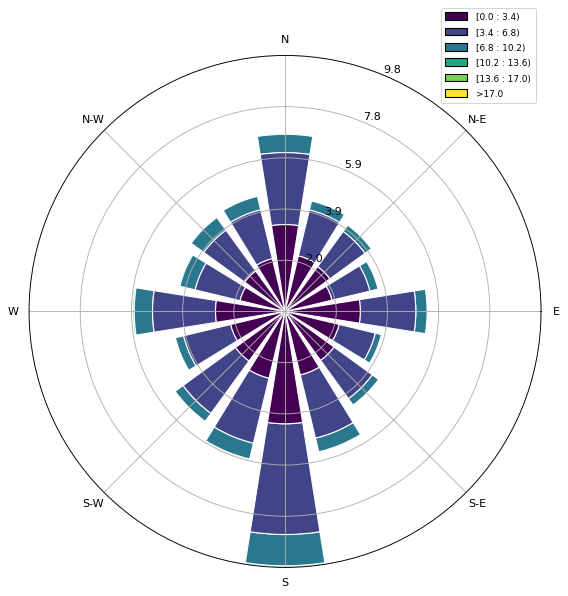

In [106]:
#Create wind speed and direction variables
ws = wind['w_speed_gor']
wd = wind['wind_direct']

#A quick way to create new windrose axes...
def new_axes():
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect, facecolor='w')
    fig.add_axes(ax)
    return ax

#...and adjust the legend box
def set_legend(ax):
    l = ax.legend(loc="right", bbox_to_anchor=(1, 1))
    plt.setp(l.get_texts(), fontsize=8)

#A stacked histogram with normed (displayed in percent) results :
ax = new_axes()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
set_legend(ax)

Преобладающие ветра для всех аэропортов **южные** (ЮЮЗ - Ю - ЮЮВ).

### Температура

In [107]:
temp_all = df.query('temp < 50').copy()
temp_all['temp'] = round(temp_all['temp'])

In [108]:
px_bar(temp_all, 'temp', 'index_nr','Температура воздуха в момент столкновений')

Большинство столкновений происходит в теплые дни при температуре 21-26 градусов.

### Среднемесячная температура

Среднемесячная температура по годам для всех аэропортов США:

In [109]:
temperature_mean = (df.query('temp < 50').pivot_table(index='year', columns='month', values='temp', aggfunc='mean')).round(1).copy()
temperature_mean

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2018,5.9,9.4,9.5,12.7,19.6,21.5,23.9,23.7,21.6,15.3,10.3,9.0
2019,7.4,8.7,10.3,15.8,17.9,21.6,23.7,23.6,21.9,16.4,9.8,8.9
2020,9.1,9.1,12.8,14.3,17.2,21.6,23.8,23.6,19.9,16.3,13.2,8.0
2021,7.6,7.5,12.5,15.3,18.1,22.5,23.5,24.1,21.2,17.9,10.8,10.1
2022,5.6,9.0,12.0,15.5,19.4,22.8,24.4,24.1,20.9,15.5,12.0,8.2
2023,8.3,8.8,9.6,15.0,18.5,21.3,23.9,23.7,NaN,NaN,NaN,NaN


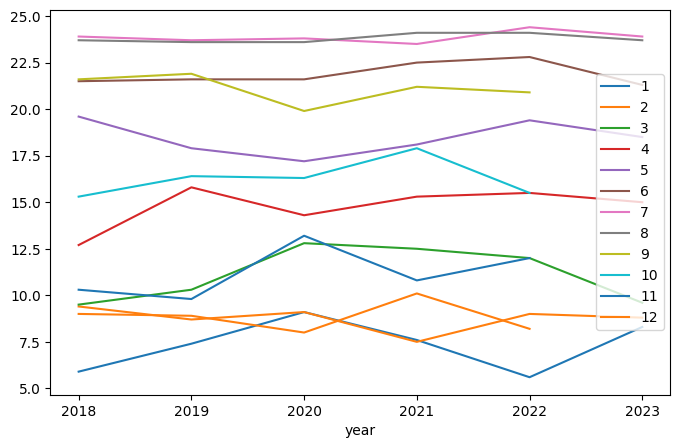

In [110]:
temperature_mean.plot(kind='line',figsize=(8,5));
plt.legend(loc='right')
plt.show()

Среднемесячная температура по годам летом более стабильная. Зимой меняется до 3 градусов.

### Сила ветра

Найдём среднемесячную скорость ветра.

In [111]:
wind_speed_mean = (df.query('w_speed_gor < 100').pivot_table(index='year', columns='month', values='w_speed_gor', aggfunc='mean')).round(1)
wind_speed_mean

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2018,3.2,3.4,3.9,3.8,3.3,3.3,2.9,2.9,3.1,3.6,3.7,3.4
2019,3.3,3.5,3.6,4.0,3.7,3.2,2.9,2.8,3.2,3.5,3.1,3.2
2020,3.5,3.6,3.6,3.9,3.4,3.2,2.8,2.8,2.9,3.1,3.6,2.9
2021,3.1,3.7,3.7,3.8,3.7,3.2,3.0,2.7,3.0,3.1,3.2,3.3
2022,3.2,3.7,3.8,4.3,3.9,3.2,3.2,2.9,3.0,3.3,3.5,3.6
2023,3.2,3.4,3.6,3.7,3.2,3.1,2.8,2.6,NaN,NaN,NaN,NaN


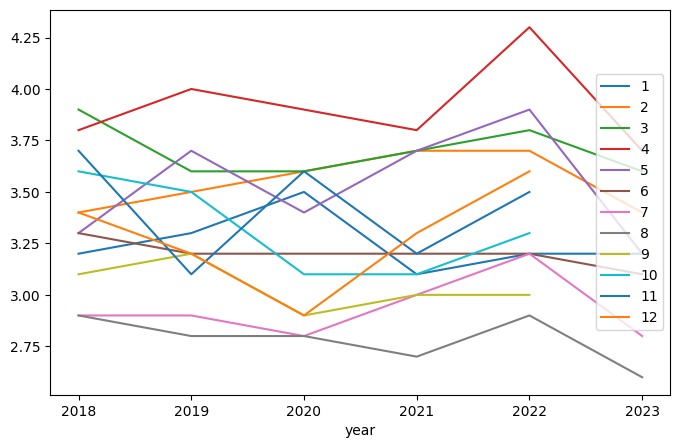

In [112]:
wind_speed_mean.plot(kind='line',figsize=(8,5));
plt.legend(loc='right')
plt.show()

Минимальная и максимальная среднемесячная скорость ветра за весь период отличается не более, чем на 1.5 м/с.

## Анализ аэропорта Мемфиса KMEW

### Описание параметров KMEM

Разберём отдельно аэропорт **KMEM** как аэропорт с наибольшим процентом столкновений с птицами.

In [113]:
kmem = df.query('airport_id == "KMEM"').copy()
kmem.shape

(1318, 53)

In [114]:
# очистим данные от выбросов (999, 9999 и т.д.)
kmem.loc[kmem['wind_direct'] > 400, 'wind_direct'] = pd.NA
kmem.loc[kmem['w_speed_gor'] > 500, 'w_speed_gor'] = pd.NA
kmem.loc[kmem['cig_dist_sky'] > 23000, 'cig_dist_sky'] = pd.NA
kmem.loc[kmem['slp_pressure'] > 11000, 'slp_pressure'] = pd.NA

Построим быстрые гистограммы:

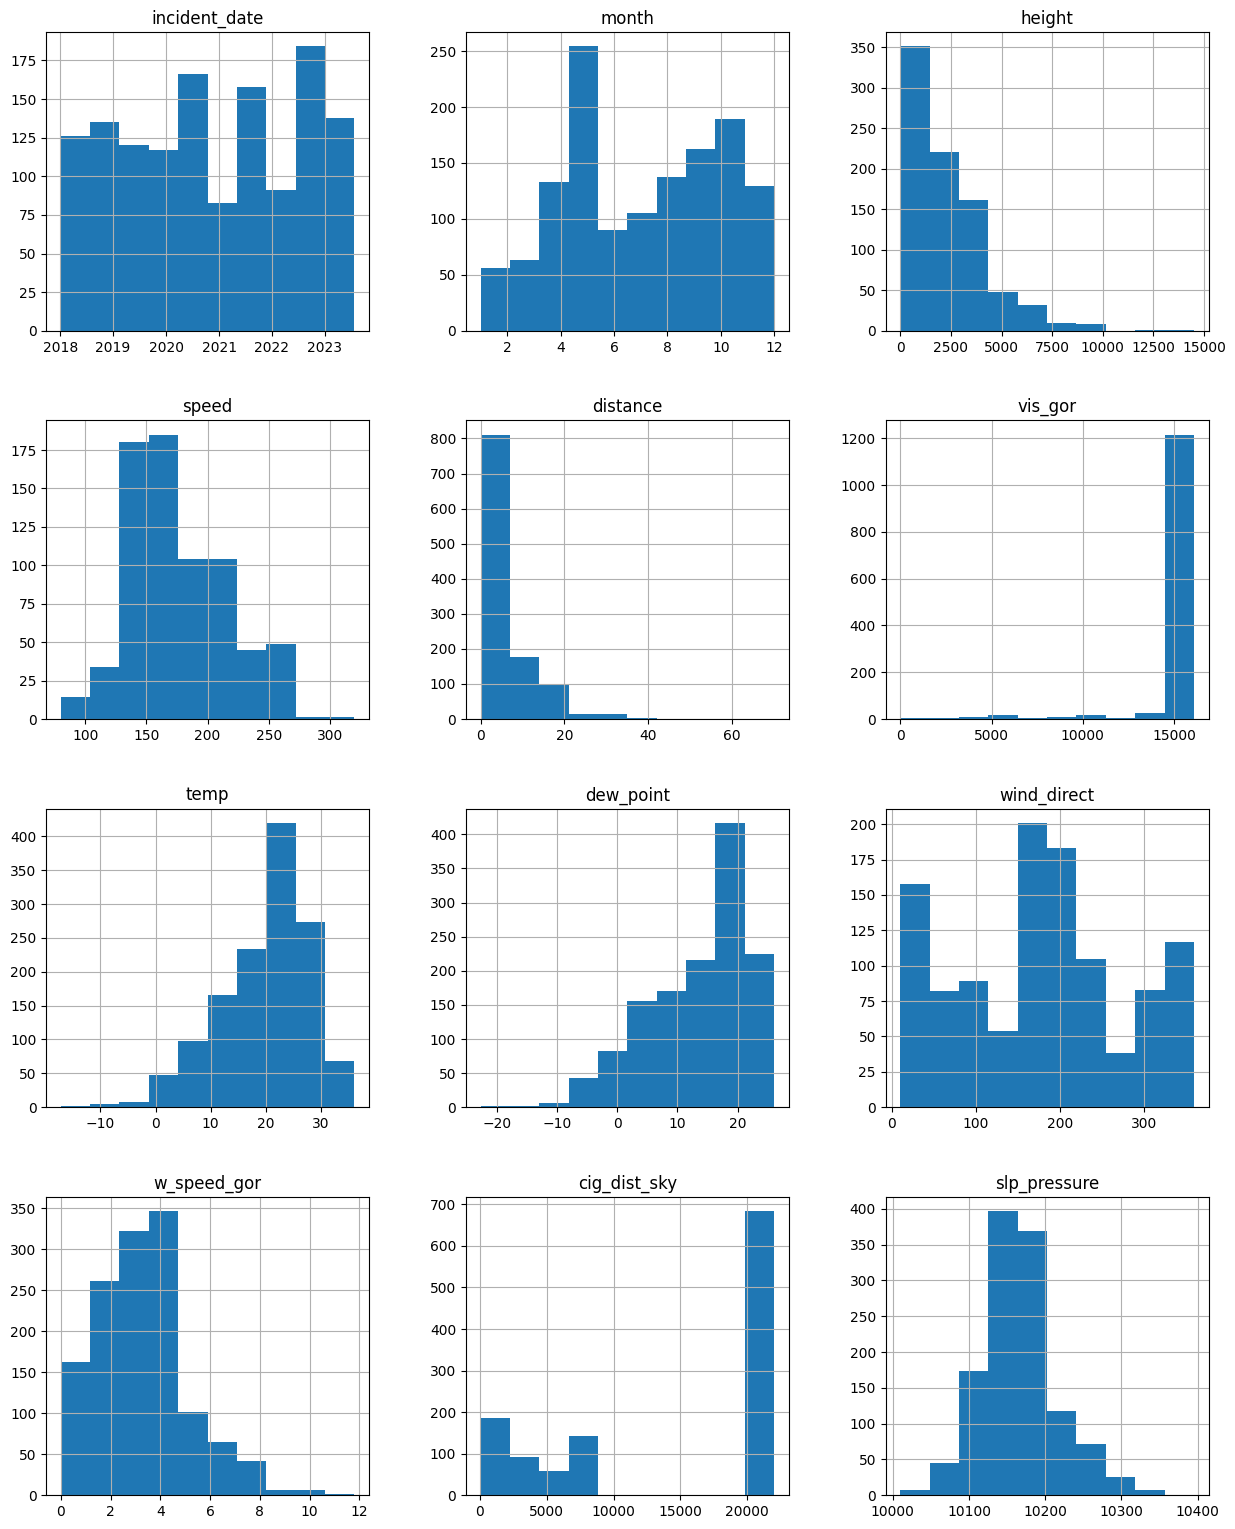

In [115]:
kmem[['incident_date', 'month', 'height', 'speed', 'distance', 'vis_gor', 'temp', 'dew_point',
      'wind_direct', 'w_speed_gor','cig_dist_sky','slp_pressure']].hist(figsize=(15,19));

**Особенности параметров при столкновениях в аэропорту Мемфиса (KMEW), штат Теннесси:**
*   Большинство столкновений происходит в мае, сентябре и октябре
*   В 2020-2022 годах распределение столкновений неравномерное
*   Большая часть приходится на начало / конец полёта (высота до 1 км)
*   Удалённость от аэропорта до 5 миль
*   Скорость самолета 150-160 узлов
*   Чаще всего столкновения происходят в тёплую погоду (20-25°)
*   Преобладающий ветер ЮЮЗ (190-200°) и ССВ (10°).
*   Горизонтальная скорость 2-4 м/с
*   Преобладающие высокие облака и атмосферное давление 10160

















**Интересное наблюдение** - больше всего столкновений происходит в теплую погоду, при этом если смотреть по месяцам, то летом (в самый теплый сезон) столкновений меньше, чем в конце весны или осенью. Возможно, зависимость не столько от температуры, сколько от сезона в целом. Проверим эту гипотезу позже.

### Направление ветра KMEM

In [116]:
kmem_wind = df[(df['wind_direct'] < 400) & (df['airport_id'] == "KMEM")].copy()
kmem_wind['wind_direct'] = round(kmem_wind['wind_direct'] / 10) * 10
kmem_wind['wind_direct'] = kmem_wind['wind_direct'].astype('int')

In [117]:
kmem_wind = kmem_wind[kmem_wind['w_speed_gor'] < 18].copy()
kmem_wind['w_speed_gor'] = kmem_wind['w_speed_gor'].round()

In [118]:
px_sort(kmem_wind, 'w_speed_gor', 'index_nr', 'Столкновение в аэропорте KMEM при разной силе ветра', 500, 1000)

In [119]:
px_sort(kmem_wind, 'wind_direct', 'index_nr', 'Столкновения в аэропорте KMEM при разном направлении ветра', 500, 1000)

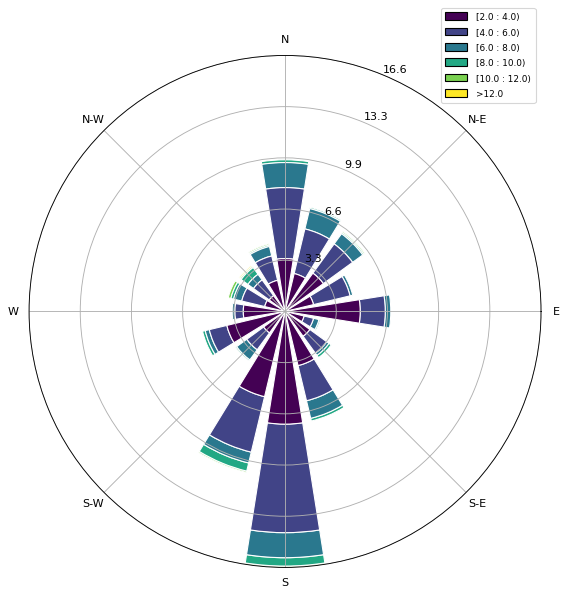

In [120]:
#Create wind speed and direction variables
ws = kmem_wind['w_speed_gor']
wd = kmem_wind['wind_direct']

#A quick way to create new windrose axes...
def new_axes():
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect, facecolor='w')
    fig.add_axes(ax)
    return ax

#...and adjust the legend box
def set_legend(ax):
    l = ax.legend(loc="right", bbox_to_anchor=(1, 1))
    plt.setp(l.get_texts(), fontsize=8)

#A stacked histogram with normed (displayed in percent) results :
ax = new_axes()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
set_legend(ax)

Преобладающий ветер - **южный (ЮЮВ-Ю-ЮЮЗ)**. На втором месте **северный (С-ВСВ)**. Остальные ветра встречаются редко.

Сравним график с розой ветров Мемфиса:

<img src="https://drive.usercontent.google.com/download?id=1kA3jEZQI1Vqo7XcfclmguHYLSgiINJvv&export=download&authuser=0&confirm=t&uuid=116112f6-3c63-44cb-9fec-fd9c42097738&at=APZUnTWS9yo-Rshh0-xS6G6GhIEn:1696805321943" width="810" height="600">

Можно было бы выдвинуть гипотезу, что при южных ветрах столкновений происходит больше, но роза ветров Мемфиса очень похожа на наш график, то есть преобладающие южные ветра являются естесственной погодной характеристикой.

# ПРОВЕРКА ГИПОТЕЗ

## **Гипотеза №1**   
**Большее количество столкновений с птицами в аэропорту KMEM происходит в тёплые дни (18-28 градусов) в мае, сентябре и октябре, чем в такие же теплые дни летом.**

In [121]:
kmem_temp_mean = kmem.pivot_table(index='year', columns='month', values='temp', aggfunc='mean').round(1).copy()
kmem_temp_mean

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2018,2.2,7.9,14.5,13.9,23.2,25.6,26.1,25.9,23.3,18.6,8.9,4.5
2019,10.6,7.5,13.3,19.5,23.7,22.8,24.8,26.5,26.4,16.0,4.8,4.8
2020,4.8,6.3,12.0,15.3,19.8,25.1,27.7,26.1,22.9,15.6,13.6,6.2
2021,10.0,11.3,17.6,21.3,20.8,26.4,28.5,26.9,23.3,20.6,10.0,9.5
2022,NaN,5.1,10.8,19.1,22.7,28.4,30.0,26.7,24.3,15.9,15.0,3.8
2023,11.3,6.6,11.4,15.3,21.9,23.9,26.8,NaN,NaN,NaN,NaN,NaN


In [122]:
kmem_temp_5years = kmem.pivot_table(columns='month', values='temp', aggfunc='mean').round(1).copy()
kmem_temp_5years

month,1,2,3,4,5,6,7,8,9,10,11,12
temp,7.0,7.5,13.1,17.3,21.9,25.6,27.4,26.4,24.1,17.2,10.5,5.5


In [123]:
kmem_t_round = kmem.copy()
kmem_t_round['temp'] = round(kmem_t_round['temp'])
px_sort(kmem_t_round, 'temp', 'index_nr', 'Количество страйков от температуры', 700, 1100)

In [124]:
px_sort(kmem, 'month', 'index_nr', 'Количество страйков от месяца', 700, 1100)

Для проверки гипотезы разобъем все страйки аэропорта KMEM **на три кластера по температуре - до 18°, 18-28 и более 28°** и посмотрим на распределение по месяцам.

In [125]:
kmem_hot = kmem.query('temp > 17 & temp < 29').copy()
kmem_hot_count = kmem_hot.pivot_table(index=['year','month'], values='index_nr', aggfunc='count').reset_index().copy()
kmem_hot_count = kmem_hot_count.rename(columns={'index_nr':'strikes'})

fig = px.bar(kmem_hot_count, x='month', y='strikes', title = 'Страйки в тёплую погоду 18-28° по месяцам (2018-2023)')
fig.update_layout(height=500, width=1000)
fig.show()

In [126]:
kmem_cold = kmem.query('temp < 18').copy()
kmem_cold_count = kmem_cold.pivot_table(index=['year','month'], values='index_nr', aggfunc='count').reset_index().copy()
kmem_cold_count = kmem_cold_count.rename(columns={'index_nr':'strikes'})

fig = px.bar(kmem_cold_count, x='month', y='strikes', title = 'Страйки в холодную погоду до 18° по месяцам (2018-2023)')
fig.update_layout(height=500, width=1000)
fig.show()

In [127]:
kmem_hot28 = kmem.query('temp > 28').copy()
kmem_hot28_count = kmem_hot28.pivot_table(index=['year','month'], values='index_nr', aggfunc='count').reset_index().copy()
kmem_hot28_count = kmem_hot28_count.rename(columns={'index_nr':'strikes'})

fig = px.bar(kmem_hot28_count, x='month', y='strikes', title = 'Страйки в жаркую погоду выше 28° по месяцам (2018-2023)')
fig.update_layout(height=500, width=1000)
fig.show()

**Гипотеза подтвердилась:**  
**Большее количество столкновений с птицами в аэропорту KMEM происходит в тёплые дни (18-28 градусов) в мае, сентябре и октябре, чем в такие же теплые дни летом.**  
Мы видим, что в теплые дни весной и осенью, при температуре 18-28° действительно гораздо больше столкновений. Плотность столкновений в день в мае, сентябре и октябре выше (90-210 страйков), чем в тёплые дни этого же диапазона летом (70-100 страйков).  
**Неожиданный инсайт** - летом, в дни с температурой до 18°, за 5 лет не было ни одного столкновения! А в жаркие дни с температурой более 28° столкновение с птицой вероятнее летом, чем в пиковые месяцы - мае, сентябре и октябре.

## **Гипотеза №2**  
**Есть общие параметры в погоде, объединяющие дни с пиковыми страйками (от 5 и более страйков в день) во всех аэропортах.**

Для проверки данной гипотезы создадим датасет с максимальным количеством страйков в день по аэропортам.

In [128]:
# создадим колонку с кол-вом инцидентов в день по конкертному аэропорту (проранжируем)
df['count'] = df.groupby(['incident_date', 'airport_id'])['airport_id'].transform('count')

In [129]:
max_strike = df.query('count > 4')
max_strike.shape

(11762, 54)

In [130]:
max_strike['incident_date'].nunique()

1025

Построим быстрые гистограммы для анализа:

In [131]:
# очистим данные от выбросов (999, 9999 и т.д.)
max_strike.loc[max_strike['wind_direct'] > 400, 'wind_direct'] = pd.NA
max_strike.loc[max_strike['w_speed_gor'] > 500, 'w_speed_gor'] = pd.NA
max_strike.loc[max_strike['cig_dist_sky'] > 23000, 'cig_dist_sky'] = pd.NA
max_strike.loc[max_strike['slp_pressure'] > 11000, 'slp_pressure'] = pd.NA

max_strike.loc[max_strike['temp'] > 50, 'temp'] = pd.NA
max_strike.loc[max_strike['dew_point'] > 50, 'dew_point'] = pd.NA
max_strike.loc[max_strike['height'] > 15000, 'height'] = pd.NA
max_strike.loc[max_strike['speed'] > 600, 'speed'] = pd.NA
max_strike.loc[max_strike['distance'] > 40, 'distance'] = pd.NA

In [132]:
max_strike['airport_id'].value_counts().head(10)

ZZZZ    9209
KDEN    1000
KDFW     269
KORD     164
KMEM     154
KDTW     126
KJFK      85
KSDF      84
KATL      59
KEWR      48
Name: airport_id, dtype: int64

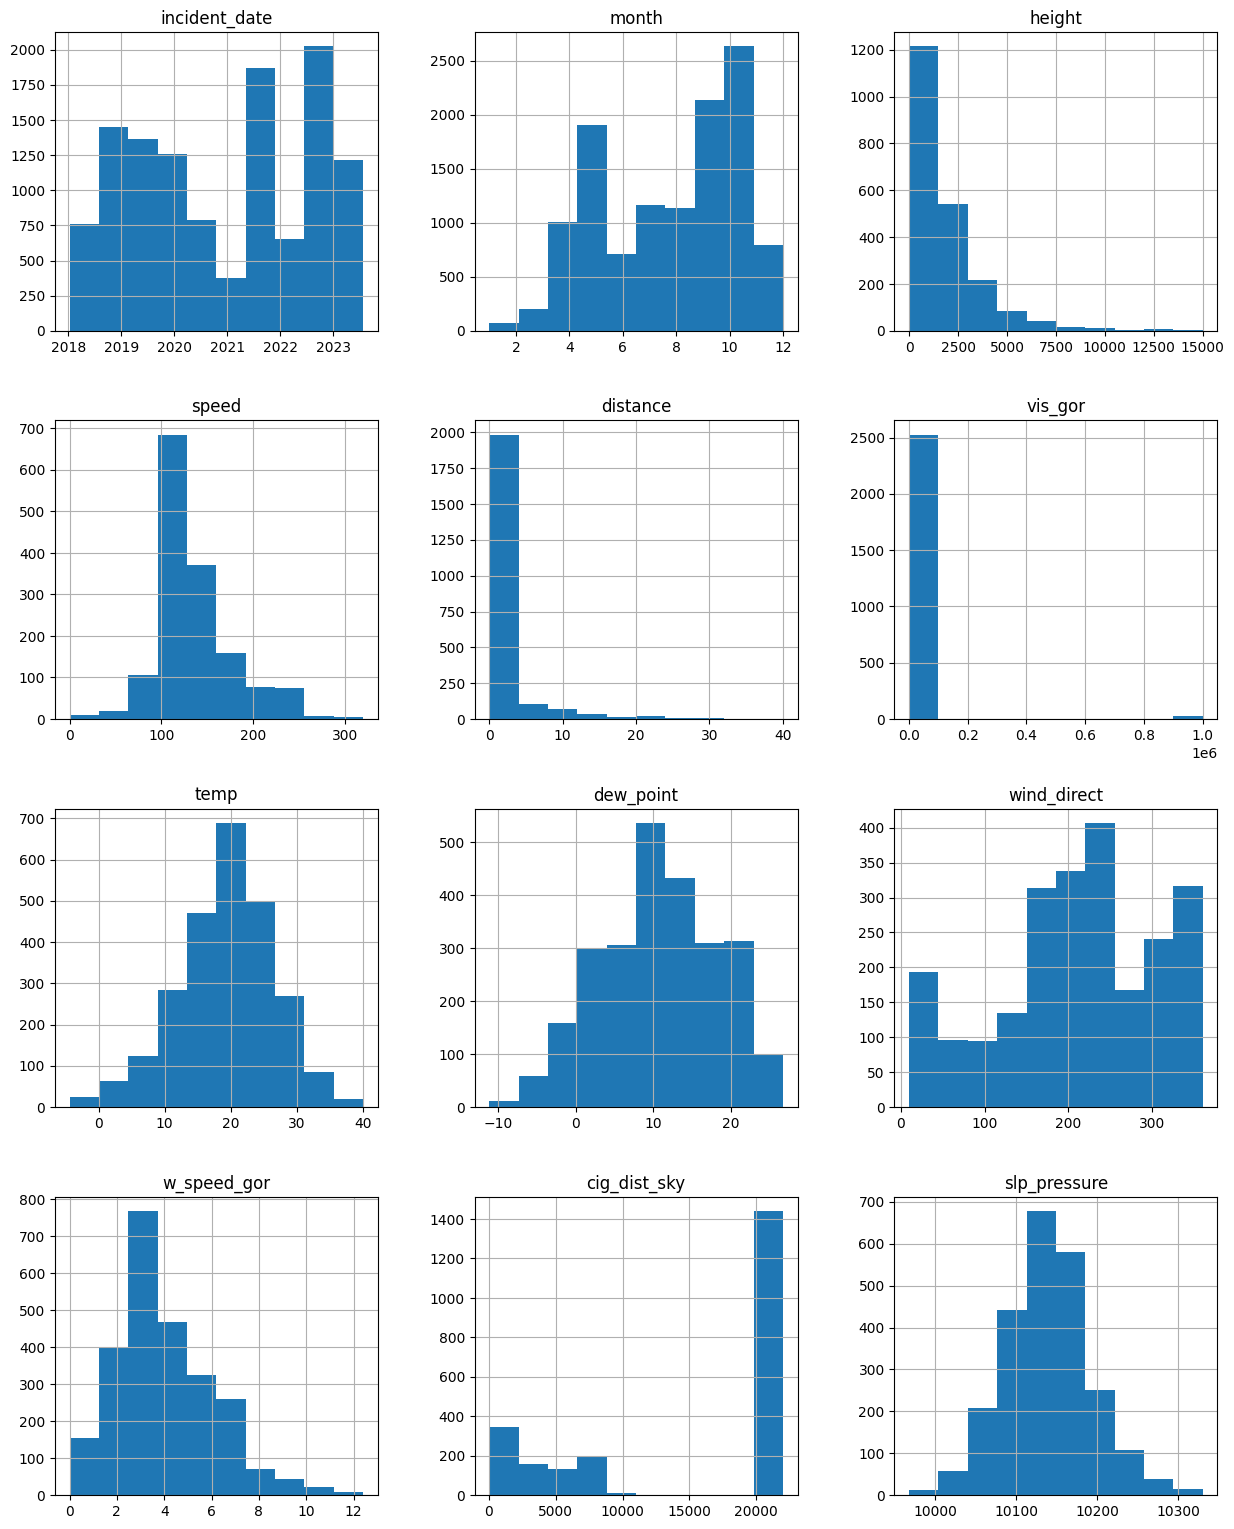

In [133]:
max_strike[['incident_date', 'month', 'height', 'speed', 'distance', 'vis_gor', 'temp', 'dew_point',
            'wind_direct', 'w_speed_gor','cig_dist_sky','slp_pressure']].hist(figsize=(15,19));

**Особенности параметров в дни, когда происходит от 5 и более столкновений в одном аэропорту:**  
*   Такие дни чаще встречаются в мае, сентябре и октябре (в то время как единичные столкновения чаще приходятся на летние месяцы)
*   Точка росы смещена на 10 градусов относительно температуры воздуха (в общих данных она, как правило совпадает с ней). Необходимо исследовать этот параметр дополнительно, непонятно с чем связана такая разница - ошибки или действительно другая влажность.
*   По сравнению с главным датасетом, направление ветра смещено к Юго-западному (вместо Южного и Юго-восточного), и еще меньше Северо-восточных - Юго восточных ветров





Ниже, к сравнению, графики общего датасета по отличающимся параметрам:

In [134]:
df_hist = df.copy()

In [135]:
# очистим данные от выбросов (999, 9999 и т.д.)
df_hist.loc[df_hist['wind_direct'] > 400, 'wind_direct'] = pd.NA
df_hist.loc[df_hist['w_speed_gor'] > 20, 'w_speed_gor'] = pd.NA
df_hist.loc[df_hist['cig_dist_sky'] > 23000, 'cig_dist_sky'] = pd.NA
df_hist.loc[df_hist['slp_pressure'] > 11000, 'slp_pressure'] = pd.NA

df_hist.loc[df_hist['temp'] > 50, 'temp'] = pd.NA
df_hist.loc[df_hist['dew_point'] > 50, 'dew_point'] = pd.NA
df_hist.loc[df_hist['height'] > 15000, 'height'] = pd.NA
df_hist.loc[df_hist['speed'] > 600, 'speed'] = pd.NA
df_hist.loc[df_hist['distance'] > 40, 'distance'] = pd.NA

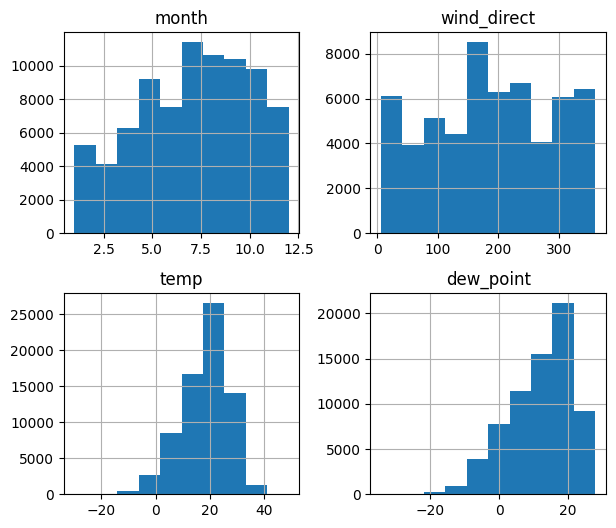

In [136]:
df_hist[['month', 'wind_direct', 'temp', 'dew_point']].hist(figsize=(7,6));

Сузим воронку до самых массовых столкновений - от 12 и более в день:

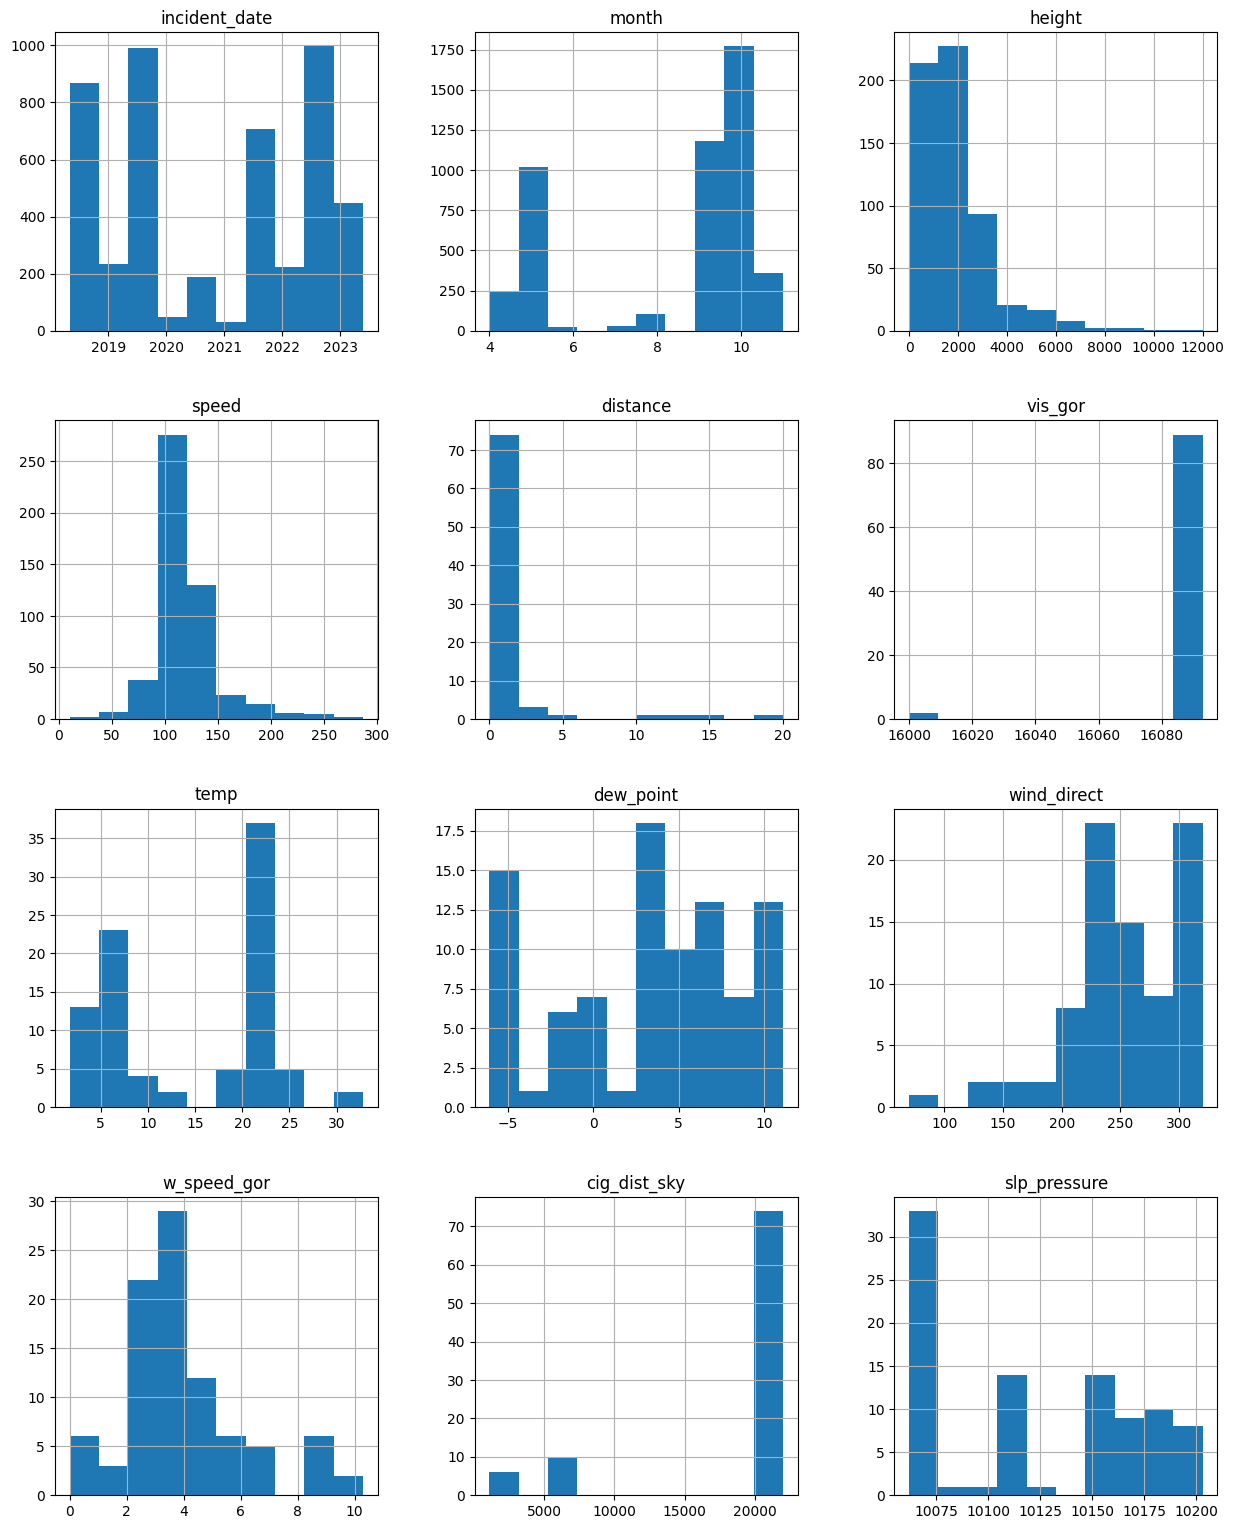

In [137]:
max_strike_12 = max_strike.query('count > 11').copy()
max_strike_12[['incident_date', 'month', 'height', 'speed', 'distance', 'vis_gor', 'temp', 'dew_point',
               'wind_direct', 'w_speed_gor','cig_dist_sky','slp_pressure']].hist(figsize=(15,19));

**Особенности параметров в дни, когда происходит от дюжины и более столкновений в одном аэропорту:**  
*   Такие столкновения встречаются в мае, сентябре и октябре (в другие месяцы их практически нет)
*   Распределение таких событий по годам неравномерное - в 2020 и 2021 меньше.
*   Точка росы попрежнему смещена на 10 или более градусов относительно температуры воздуха (в общих данных она, как правило совпадает с ней).
*   Температура при таких столкновениях около 22 градусов (ниже, чем у единичных), а также второй пик около 6 градусов (точка росы отрицательная).
*   Увеличилась высота полёта - 1-2 км (вместо 0-1 км).
*   Скорость ниже - 100-130 узлов.
*   Направление ветра преимущественно Юго-западное и Северо-западное.

Таким образом, есть некоторые отличия в параметрах от дней, с малым количеством столкновений, но на данном этапе непонятно существенны они или нет.   
**Гипотеза требует доработки.**  
Необходимо дополнительно проверить данные по точке росы и ее зависимость с температурой при большом количестве столкновений в день.   

# ОБЩИЙ ВЫВОД

Сделан исследовательский анализ зависимости столкновений птиц с самолетами от погодных условий, сезонов и других параметров. Проведена полная предобработка данных:
- знакомство с большим объемом параметров и сужение их до необходимых столбцов
- перевод дат и времени в правильный формат, а также очистка от некорректных значений
- проверка диапазона дат, равномерность собранных данных, дубликатов
- очистка данных от НЕ птиц (распознавание по реестру и удаление строк)
- перевод единиц измерения в универсальный формат
- проверка соответствия двух датасетов по ТОП-22 аэропортов


На начальном этапе было принято решение удалить все строки с нелетающими животными, и сосредоточиться только на столкновениях с птицами. Диапазон в 5 лет и 8 месяцев не стали сокращать, так как почти год данных - это ценная информация.

**Результат исследовательского анализа по всем аэропортам**
- Существует сезонность в ТОП-10 аэропортах - летом полетов больше (июль, август), зимой - меньше (январь, февраль)
- 14 % столкновений произошли в небольших аэропортах, которые не зарегистрированы в ИКАО.
- Топовые аэропорты по проценту столкновений с птицами - это KMEM (Мемфис, штат Теннесси) и KSDF (Луисвилль, штат Кентуки).
- По общим данным больше всего столкновений происходит летом (с конца весны до начала осени), меньше всего столкновений зимой. Это коррелирует с сезонностью
- Больше всего столкновений происходит в утренние часы - с 7 до 10. Меньше всего столкновений ночью - с 0 до 5 ч.
- Столкновения происходят в теплое время при температуре воздуха 21-26 градусов
- Большинство столкновений происходит при заходе на посадку. Также часты случае при посадочном развороте (руление по земле после приземления), при взлёте (разбег до момента отрыва от полосы), при наборе высоты.
- По данным, больше половины столкновений происходит прямо в аэропорту (0 миль). Возможно, часть нулей это пропуски данных.
- Чем ниже летит самолет, тем больше столкновений с птицами.

**УРОН**
- Только в 4,5% случаев при столкновении с птицами происходит какой-либо урон самолёту
- Менее, чем в 1% случаях самолет получает существенные повреждения. И в единичных случаях (6 самолетов за 5 лет) не подлежит восстановлению

**Параметры погоды**
- По общим данным больше всего столкновений происходит в летние месяцы
- В момент столкновения скорость ветра чаще всего от 2 до 4 метров в секунду (нулевые значения скорее всего являются пропусками в данных)
- Общие преобладающие ветра по аэропортам США южные (ЮЮЗ - Ю - ЮЮВ)

**Изменчивость среднемесячных параметров**
- Среднемесячная температура по годам летом более стабильная. Зимой меняется до 3 градусов
- Минимальная и максимальная среднемесячная скорость ветра за весь период отличается не более, чем на 1.5 м/с



**Исследование аэропорта KMEM (Мемфис, штат Теннесси), особенности параметров при столкновениях:**  
- Имеет самый большой процент столкновений по полетам
- Не имеет сезонности в рейсах
- Большинство столкновений происходит в мае, сентябре и октябре
- В 2020-2022 годах распределение столкновений неравномерное
- Большая часть приходится на начало / конец полёта (высота до 1 км)
- Удалённость от аэропорта до 5 миль
- Скорость самолета 150-160 узлов
- Чаще всего столкновения происходят в тёплую погоду (20-25°)
- Преобладающий ветер ЮЮЗ (190-200°) и ССВ (10°).
- Горизонтальная скорость 2-4 м/с
- Преобладающие высокие облака и атмосферное давление 10160
- Преобладающий ветер - южный (ЮЮВ-Ю-ЮЮЗ). На втором месте северный (С-ВСВ). Остальные ветра встречаются редко. Роза ветров по столкновениям сильно совпадает с розой Мемфиса

**Проверка гипотез**  
**Гипотеза №1**  
Большее количество столкновений с птицами в аэропорту KMEM происходит в тёплые дни (18-28 градусов) в мае, сентябре и октябре, чем в такие же теплые дни летом.    
**Подтвердилась:**  
Видим, что в теплые дни весной и осенью, при температуре 18-28° действительно гораздо больше столкновений. Плотность столкновений в день в мае, сентябре и октябре выше (90-210 страйков), чем в тёплые дни этого же диапазона летом (70-100 страйков).
Неожиданный инсайт - летом, в дни с температурой до 18°, за 5 лет не было ни одного столкновения! А в жаркие дни с температурой более 28° столкновение с птицой вероятнее летом, чем в пиковые месяцы - мае, сентябре и октябре.


**Гипотеза №2**  
Есть общие параметры в погоде, объединяющие дни с пиковыми страйками (от 5 и более страйков в день) во всех аэропортах.  
**Гипотеза требует доработки:**   
Массовые столкновения почти всегда происходят в мае, сентябре и октябре. Распределение таких событий по годам неравномерное - в 2020 и 2021 меньше. Появляется второй пик температуры около 6 градусов (холодно). Наблюдается смещение точки росы на -10 градусов от температуры. Преобладают другие ветра - Юго-западный и Северо-западной (вместо Южного и Юго-восточного). Почти отсутствуют Северо-восточные - Восточные - Юго восточные ветра. Увеличилась высота полета - 1-2 км (вместо 0-1). Ниже скорость - 100-130 узлов




Рекомендации: для дальнейших исследований необходимы данные по полетам без страйков за этот же период по дням.

# Датасеты для скачивания:

In [138]:
# очищенный и сокращенный data_DE_strikes_and_weather  (все столкновения по всем аэропортам с погодой)
df.to_csv('df.csv', index=False)
#files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [139]:
# сагрегированный датасет по ТОП-22 аэропорта - все полеты, полеты со столкновениями, процент %  полетов со столкновениями
flight_ratio.to_csv('flight_ratio.csv', index=False)
#files.download('flight_ratio.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [140]:
# датасет по аэропорту KMEM (Мемфис)
kmem.to_csv('kmem.csv', index=False)
#files.download('kmem.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [141]:
# датасет с аэропортами с большим количеством страйков по дням - более 5 (ранжировка в столбце count ), выбросы по погоде заменены на NaN
max_strike.to_csv('max_strike.csv', index=False)
#files.download('max_strike.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>